08/25/2020

check vocab words
1. make sure they are in the rna expression


08/30 finish gathering genomic instances

In [103]:
# basic packages
import re
import os, glob
import pandas as pd
import numpy as np; np.random.seed(0)
import itertools
from collections import Counter, defaultdict
import time
# Import tools needed for visualization
import seaborn as sns; sns.set()
import matplotlib
import matplotlib.pyplot as plt
import pybedtools

In [104]:
save_dir = '../data/processed/fig4_modelling/vocab_sum_final/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# 1 Get the vocab words

In [904]:
vocab_dict = {'Colon':pd.read_excel('../data/processed/fig4_modelling/vocab_sum/Colon_filtered_vocab_list.xlsx',header=None).loc[:,0].values,
'Melanocytes':pd.read_excel('../data/processed/fig4_modelling/vocab_sum/Melanocytes_filtered_vocab_list.xlsx',header=None).loc[:,0].values,
'GDSD6':pd.read_excel('../data/processed/fig4_modelling/vocab_sum/GDSD6_filtered_vocab_list.xlsx',header=None).loc[:,0].values,
 'GM12878':pd.read_excel('../data/processed/fig4_modelling/vocab_sum/GM12878_filtered_vocab_list.xlsx',header=None).loc[:,0].values,
'SCC':pd.read_excel('../data/processed/fig4_modelling/vocab_sum/SCC_filtered_vocab.xlsx',header=None).loc[:,0].values,
 'MM':pd.read_excel('../data/processed/fig4_modelling/vocab_sum/MM_filtered_vocab_list.xlsx',header=None).loc[:,0].values

}

vocab_df = pd.DataFrame(columns=['tissue','vocab'])
for tissue, vocab_arr in vocab_dict.items():
    for vocab in vocab_arr:
        vocab_df = vocab_df.append({'tissue':tissue, 'vocab':vocab},ignore_index=True)
vocab_df['source'] = 'enrich'

In [905]:
irf_df = pd.read_excel('../data/processed/fig4_modelling/irf_manual_lookup.xlsx')
irf_df = irf_df[irf_df['Y/n?']=='Y']
irf_df = irf_df[['Vocab','Tissue']]
irf_df.columns = ['vocab', 'tissue']
irf_df['vocab'] = irf_df.vocab.str.split('[:_]',expand=True).iloc[:,[0,3]].agg('::'.join, axis=1)
irf_df['source'] = 'irf'

In [906]:
overall_df = pd.concat([vocab_df, irf_df],axis=0,sort=False)
overall_df[['vocab1','vocab2']] = overall_df.vocab.str.split('::',expand=True)
overall_df.drop_duplicates(inplace=True)
overall_df.reset_index(inplace=True, drop=True)

In [907]:
overall_df[:5]

,tissue,vocab,source,vocab1,vocab2
0,Colon,BARX2::DLX4,enrich,BARX2,DLX4
1,Colon,BARX2::FOXF2,enrich,BARX2,FOXF2
2,Colon,BARX2::FOXM1,enrich,BARX2,FOXM1
3,Colon,BARX2::THAP1,enrich,BARX2,THAP1
4,Colon,BATF::KLF15,enrich,BATF,KLF15


In [908]:
overall_df.to_csv(os.path.join(save_dir, 'overall_df.csv'))

##  1B. some basic stats

In [909]:
overall_df.tissue.value_counts()

Melanocytes    132
GDSD6           94
Colon           85
GM12878         64
MM              53
SCC             45
Name: tissue, dtype: int64

In [910]:
overall_df.shape

(473, 5)

In [911]:
len(overall_df.vocab.unique())

472

currently 472 unique vocab pairs for each tissue

In [913]:
motifs =set( list(overall_df.vocab1)+ list(overall_df.vocab2))
len(motifs)

248

using 248 vocabulary words

In [914]:
motif_to_tissue = {}
for motif in motifs:
    motif_to_tissue[motif] = {'Colon':0,'GDSD6':0,'GM12878':0, 'Melanocytes':0,'SCC':0,'MM':0}
for idx, row in overall_df.iterrows():
    motif_to_tissue[row['vocab1']][row['tissue']]+=1
    motif_to_tissue[row['vocab2']][row['tissue']]+=1

In [915]:
motif_to_tissue_df = pd.DataFrame.from_dict(motif_to_tissue,orient='index')

In [916]:
motif_to_tissue_df.to_csv(os.path.join(save_dir, 'motif_to_tissue.csv'))

## 1C. check to see if the vocab words are in the irf model somewhere

In [917]:
tissue_to_irf_file  = {
    'Colon': '../data/processed/fig4_modelling/tf_tf_pairs_stability_sherlock/expr_Colon_Colon_boosted_stability_score.csv',
    'GDSD6': '../data/processed/fig4_modelling/tf_tf_pairs_stability_sherlock/expr_GDSD6_GDSD6_boosted_stability_score.csv',
    'GM12878': '../data/processed/fig4_modelling/tf_tf_pairs_stability_sherlock/expr_GM12878_GM12878_boosted_stability_score.csv',
    'Melanocytes': '../data/processed/fig4_modelling/tf_tf_pairs_stability_sherlock/expr_Melanocytes_Melanocytes_boosted_stability_score.csv',
    'MM': '../data/processed/fig4_modelling/irf_manual_mm/expr_cancer_boosted_stability_score.csv',#'../data/processed/fig4_modelling/irf_manual_mm/diff_cancer_boosted_stability_score.csv'
    'SCC': '../data/processed/fig4_modelling/irf_manual_scc/expr_cancer_boosted_stability_score.csv',#'../data/processed/fig4_modelling/irf_manual_scc/diff_cancer_boosted_stability_score.csv'
    
}

In [918]:
%%time
# takes about 5 min, slow 
overall_df['irf_found'] = ''
overall_df['irf_score_found'] = 0.0
for idx, row in overall_df.iterrows():
    print(idx)
    vocab1, vocab2 = row['vocab1'], row['vocab2']
    tissue = row['tissue']
    irf_file = tissue_to_irf_file[tissue]
    
    irf_df = pd.read_csv(irf_file).sort_values('score',ascending=False)
    found_vocab_pair = False
    jdx = 0
    while (not found_vocab_pair )and (jdx < irf_df.shape[0]) :
        row_irf = irf_df.loc[irf_df.index[jdx],:]
        irf_vocab = row_irf['index']
        score = row_irf['score']
        if (vocab1 in irf_vocab) & (vocab2 in irf_vocab):
            found_vocab_pair = True
            overall_df.at[idx, 'irf_found'] = irf_vocab
            overall_df.at[idx,'irf_score_found'] = score
        jdx+=1
    

        
        

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [919]:
overall_df[overall_df.irf_score_found>0].shape

(63, 7)

In [920]:
irf_vocab = overall_df[overall_df.irf_score_found>0].vocab.values

63 of the 455 are from irf

In [929]:
overall_df.to_csv(os.path.join(save_dir, 'overall_df.csv'))

# 2. check RNA expression

In [922]:
rna_df = pd.read_csv('../data/interim/rna/tissue_tpm_sym.csv',index_col=0)
print(rna_df.columns)

Index(['A431-CTRLi', 'A431-p63i', 'Airway', 'Astrocytes', 'Bladder',
       'CAL27-CTRLi', 'CAL27-p63i', 'COLO_SCR_DMSO', 'COLO_SCR_PLX',
       'COLO_shMITF_DMSO', 'COLO_shMITF_PLX', 'Colon', 'D0-CTRLi', 'D0-p63i',
       'D3-CTRLi', 'D3-p63i', 'Esophageal', 'GDSD0', 'GDSD3', 'GDSD6',
       'GM12878', 'HMEC', 'Melanocytes', 'Ovarian', 'Pancreas', 'Prostate',
       'Renal', 'SCC13-CTRLi', 'SCC13-p63i', 'SKMEL5_SCR_DMSO',
       'SKMEL5_SCR_PLX', 'SKMEL5_shMITF-DMSO', 'SKMEL5_shMITF_PLX', 'Thyroid',
       'Uterine', 'WM_SCR_DMSO', 'WM_SCR_PLX', 'WM_shMITF_DMSO',
       'WM_shMITF_PLX'],
      dtype='object')


In [923]:
motifs_with_rna_sym = motif_to_tissue_df.index[[True if x in rna_df.index.values else False for x in motif_to_tissue_df.index]]
len(motifs_with_rna_sym)

248

In [924]:
motif_to_tissue_df.index[~np.array([True if x in rna_df.index.values else False for x in motif_to_tissue_df.index])]
# all motifs are rna symbols

Index([], dtype='object')

In [925]:
rna_df_tf = rna_df.loc[sorted(motif_to_tissue_df.index.values),['Colon','GDSD6','GM12878','Melanocytes','A431-CTRLi','CAL27-CTRLi','SCC13-CTRLi','COLO_SCR_DMSO','WM_SCR_DMSO']]
rna_df_tf.to_csv(os.path.join(save_dir, 'rna_df_tf.csv'))

# 2B. manual check for RNA TF to have TPM >1

files to compare: `'../data/processed/fig4_modelling/vocab_sum_final/motif_to_tissue_log.pdf'`
'../data/processed/fig4_modelling/vocab_sum_final/rna_df_tf_bin.pdf'


In [926]:
THRES=1

In [927]:
check_rna = pd.DataFrame(rna_df_tf[motif_to_tissue_df==1].fillna(2)>THRES).unstack().reset_index()
check_rna.columns = ['tissue','motif', 'pass_exp_filt']
check_rna[check_rna.pass_exp_filt==False]

,tissue,motif,pass_exp_filt
133,Colon,NR1D1,False
191,Colon,STAT5A,False
439,GDSD6,STAT5A,False
554,GM12878,GATA2,False
613,GM12878,MITF,False
834,Melanocytes,JDP2,False


manually pick motifs to remove

In [930]:
overall_df[(overall_df.vocab1=='NR1D1') |(overall_df.vocab2=='NR1D1') ]

,tissue,vocab,source,vocab1,vocab2,irf_found,irf_score_found
423,Colon,NFYC::NR1D1,irf,NFYC,NR1D1,NFYC_loop::NR1D1_loop,0.892857


In [931]:
bad_tfs = ['NR1D1','STAT5A','GATA2', 'JDP2'] 

In [932]:
# testing
# rna_df.loc['STAT5A',:] # not expressed in KRT (0.045)
# rna_df.loc['GATA2',:] # not expressed in GM12878 (0.35)
# rna_df.loc['FOSL1',:] # not expressed in GM12878 (0.635)
# rna_df.loc['JDP2',:] # not expressed in Melanocytes (0.434)
# rna_df.loc['NR1D1',:] # not expressed in Colon (0.160)
# rna_df.loc['MITF',:] # not expressed in GM but going to keep b/c needed in KRT
# rna_df.loc['SMAD4',:]

In [933]:
overall_df_filt = overall_df[(~overall_df.vocab1.isin(bad_tfs)) & (~overall_df.vocab2.isin(bad_tfs))]

In [934]:
print(overall_df.shape)
print(overall_df_filt.shape)

(473, 7)
(467, 7)


In [935]:
overall_df_filt.tissue.value_counts()

Melanocytes    131
GDSD6           93
Colon           82
GM12878         63
MM              53
SCC             45
Name: tissue, dtype: int64

In [936]:
overall_df_filt.to_csv(os.path.join(save_dir, 'overall_df_filt.csv'))

## 2C plots in 8E1R 

# 3. pull the genomic instances and pick 10 each

## 3A get genes
(melanoma is differential genes
scc is higher threshold

In [937]:
# melanoma genes
cancer_tissues = ['COLO_SCR_DMSO', 'WM_SCR_DMSO']  # SKMEL5_SCR_DMSO doesn't have HiChIP data
normal_tissues = ['Melanocytes']#'D0-CTRLi', 'D3-CTRLi']
sel_tissues = cancer_tissues+normal_tissues
tissues_dict = dict(zip(sel_tissues,range(len(sel_tissues))))
rna_df_sel = rna_df[sel_tissues]


rna_df_sel_high = rna_df_sel[rna_df_sel.max(axis=1)>1]
rna_df_sel_high_pseudo = rna_df_sel_high+1

rna_df_sel_high_pseudo['avg_ratio'] = (rna_df_sel_high_pseudo.COLO_SCR_DMSO+rna_df_sel_high_pseudo.WM_SCR_DMSO)/(2*rna_df_sel_high_pseudo.Melanocytes)
rna_df_sel_high_pseudo['min_ratio'] = rna_df_sel_high_pseudo[['COLO_SCR_DMSO','WM_SCR_DMSO']].min(axis=1)/(rna_df_sel_high_pseudo.Melanocytes)

rna_df_sel_high_pseudo.sort_values('min_ratio',ascending=False, inplace=True)
MM_genes = sorted(rna_df_sel_high_pseudo[rna_df_sel_high_pseudo.min_ratio>2].index)

In [938]:

colon_geneset = list(rna_df['Colon'][rna_df['Colon']>5].index)
GDSD6_geneset = list(rna_df['GDSD6'][rna_df['GDSD6']>5].index)
GM12878_geneset = list(rna_df['GM12878'][rna_df['GM12878']>5].index)
MC_geneset = list(rna_df['Melanocytes'][rna_df['Melanocytes']>3].index)

In [939]:
## SCC genes
THRES=10
SCC_genes = rna_df.index[rna_df[['A431-CTRLi','CAL27-CTRLi','SCC13-CTRLi']].min(axis=1)>THRES].values


In [940]:
geneset_dict  = {
    'Colon':colon_geneset,
    'GDSD6':GDSD6_geneset,
    'GM12878':GM12878_geneset,
    'Melanocytes':MC_geneset,
    'SCC':SCC_genes,
    'MM':MM_genes
}
for tissue,geneset in geneset_dict.items():
    print(tissue, len(geneset))

Colon 6826
GDSD6 6442
GM12878 6166
Melanocytes 8688
SCC 3916
MM 1143


## 3B set up global variables and dataframes

In [941]:
tissue_to_celltype_mapper = {
    'Colon':['Colon'],
    'GDSD6':['GDSD6'],
    'GM12878':['GM12878'],
    'Melanocytes':['Melanocytes'],
    'SCC':['A431-CTRLi','CAL27-CTRLi','SCC13-CTRLi'],
    'MM':['COLO-SCR-DMSO','WM-SCR-DMSO']
}

In [942]:
%%time
# import
data_all = pd.read_csv('/Users/mguo123/Google Drive/1_khavari/omics_project-LD/pan_omics/data/processed/tissue_crms/all_count_comb_overall.csv',index_col=0,header=0)
data_all = data_all[data_all.tissue.isin(['Colon','GDSD6','GM12878','Melanocytes','A431-CTRLi','CAL27-CTRLi','SCC13-CTRLi','COLO_SCR_DMSO','WM_SCR_DMSO'])]
data_all = data_all[data_all.iloc[:,2:].sum(axis=1)>1e-1]

# expression labels
exp_label = list(np.log10(data_all.exp.values+1e-2))
labels_all  = np.array(np.array(exp_label)>THRES)


tissues_label  = data_all.tissue.values#np.array((data_all.exp>THRES).values)
tissue_num_labels =  data_all.tissue.map(tissues_dict).values
is_cancer_label = np.array(['cancer' if x in cancer_tissues  else 'normal' for x in tissues_label ])
tissues_label[tissues_label=='COLO_SCR_DMSO'] = 'COLO-SCR-DMSO'
tissues_label[tissues_label=='WM_SCR_DMSO'] = 'WM-SCR-DMSO'

genes_all = data_all.index.values
gene_to_num_dict = dict(zip(np.unique(genes_all),range(len(np.unique(genes_all)))))
genes_num_all = np.vectorize(gene_to_num_dict.get)(genes_all)


CPU times: user 1min 27s, sys: 24.2 s, total: 1min 52s
Wall time: 1min 35s


In [943]:
%%time
tissue_to_foot_df = {}
foot_tissues = ['Colon','GDSD6','GM12878','Melanocytes','A431-CTRLi','CAL27-CTRLi','SCC13-CTRLi','COLO-SCR-DMSO','WM-SCR-DMSO']
for tissue in foot_tissues:
    foot_df = pd.read_csv(os.path.join('../data/interim/annon/promoter_motif_scan/','promoter_'+tissue+'_annon.bed'),sep='\t',header=None)
    foot_df.columns = ['chr','start','stop','TSS','chr_m','start_m','stop_m','id_trim','score','strand']
    tissue_to_foot_df[tissue] = foot_df

CPU times: user 35.5 s, sys: 2.58 s, total: 38.1 s
Wall time: 25.3 s


In [9]:
tf_annon_df = pd.read_csv('../data/external/HOCOMOCOv11_annotation.csv',index_col=0)
tf_annon_df['id_trim'] = tf_annon_df['id'] + '.pwm.trim'
tf_name_to_id_dict = pd.Series(tf_annon_df.id_trim.values, index=tf_annon_df.tf.values).to_dict()
tf_id_to_name_dict = pd.Series(tf_annon_df.tf.values, index=tf_annon_df.id_trim.values).to_dict()
tf_name_to_id_abbr_dict = pd.Series(tf_annon_df.id.values, index=tf_annon_df.tf.values).to_dict()
tf_id_abbr_to_name_dict = pd.Series(tf_annon_df.tf.values, index=tf_annon_df.id.values).to_dict()


In [945]:
MAX_DIST=135


## 3C helper functions

In [946]:
def check_tf_tf_loop_occur(tf_tf_pair, tissue, geneset, data_all=data_all,tissues_label=tissues_label):  #suffixes='loop', 'pro_loop'
    tf_1, tf_2 = tf_tf_pair.split('::')
    
    # get features to look at together, list of lists
    feat_list_type = {
        'pro_pro':[tf_1 + '_pro', tf_2+'_pro'],
        'loop_loop':[tf_1 + '_loop', tf_2+'_loop'],
        'pro_loop':[tf_1 + '_pro', tf_2+'_loop'],
        'loop_pro':[tf_1 + '_loop', tf_2+'_pro']}
  
    data_all_sel = data_all[data_all.index.isin(geneset) & (tissues_label==tissue)]
    feat_type_dict = {}
    for type_feat, feat_list in feat_list_type.items():
        try:
            check_series = pd.DataFrame(data_all_sel[feat_list]>0).all(axis=1)
            feat_type_dict[type_feat+"_count"] = check_series.value_counts()[True]  
            feat_type_dict[type_feat+"_genes"] = '|'.join(check_series.index[check_series])
            
        except:
            feat_type_dict[type_feat+"_count"] = 0
            feat_type_dict[type_feat+"_genes"] = ''
            
    return feat_type_dict

def get_other_vocab_word(row, next_row):
    if row['vocab']!=next_row['vocab']:
        return False
#     else row['vocab']==next_row['vocab']
#     vocab_word = set(row['tf'])
#     vocab_set = set(row['vocab'].split('::'))
#     other_vocab = list(vocab_set -  vocab_word)[0]
    return row['tf'] != next_row['tf']

def check_distance(row,next_row,max_dist=MAX_DIST):
    if row['chr_m']==next_row['chr_m']:
        if row['stop_m']<next_row['start_m']:
            tot_dist = next_row['stop_m'] - row['start_m']
            btn_dist = next_row['start_m'] - row['stop_m']
            return (tot_dist < max_dist), tot_dist, btn_dist
    return False,-1,-1

def check_tissue(row,next_row,tfs=tf_name_to_id_dict.keys()):
    if (row['tf'] in tfs) & (next_row['tf'] in tfs):
        return 'both'
    elif (row['tf'] in tfs) | (next_row['tf'] in tfs):
        return 'one'    
    else:
        return 'none'
    
def get_hits(vocab_df,tfs=tf_name_to_id_dict.keys()):
#     print('**** reading', vocab_file)
#     vocab_df = pd.read_csv(vocab_file)
    print(vocab_df.shape)
    vocab_df.sort_values(['chr','start','stop'],inplace=True)
    idx = 0
    idx_hits = 0
    results_dict = {}
    while idx < (vocab_df.shape[0]-1):
        # look at next 
        row = vocab_df.iloc[idx,:]
        next_row = vocab_df.iloc[idx+1,:]

        check_vocab_pair = get_other_vocab_word(row,next_row)
        check_dist,tot_dist, btn_dist = check_distance(row, next_row)
        check_tissue_tf = check_tissue(row,next_row,tfs)
        if (check_dist and check_vocab_pair):
    #         print('hi',idx)
    #         print(row)
    #         print(next_row)

            results_dict[idx_hits] = {'vocab_pair':row['vocab'],'tot_dist':tot_dist,'btn_dist':btn_dist,
                                      'chr':row['chr'],'start':row['start_m'],'stop':next_row['stop_m'], 
                                      'vocab1':row['tf'],'vocab1_start':row['start_m'], 'vocab1_stop': row['stop_m'],
                                      'vocab2':next_row['tf'],'vocab2_start':next_row['start_m'], 'vocab2_stop': next_row['stop_m'],
                                      'genes':row['genes'],'num_genes':len(row['genes'].split('|')), 'tissue':row['tissue'],#'foot_tissue':row['foot_tissue'],
                                     'check_tissuetf':check_tissue_tf, 'loop_type':row['type_loop']}
            idx_hits+=1

        idx+=1
    print('num_hits',idx_hits)
    results_df = pd.DataFrame.from_dict(results_dict, orient='index').drop_duplicates()
    return results_df
    
def filter_results(results_df,min_hits_per_vocab=10):
    print('shape', results_df.shape)
    vocab_counts = results_df[['vocab_pair','chr','start','stop']].drop_duplicates().vocab_pair.value_counts()
    print('original num vocab',vocab_counts.shape[0])
    vocab_to_include = vocab_counts[vocab_counts>min_hits_per_vocab].index.values
    print('filt num vocab',vocab_to_include.shape[0])
    
    results_df_filt = results_df[results_df.vocab_pair.isin(vocab_to_include)]
    return results_df_filt

    

In [947]:
# debugging get_hits()
# vocab_df = vocab_tissue_dict['MM']
# vocab_tissue_dict['MM'][vocab_tissue_dict['MM'].vocab =='IRF3::CEBPZ']
# vocab_instances_df

## 3D get genomic instances

In [948]:
vocab_tissue_dict = {}
for tissue in geneset_dict.keys():
    vocab_tissue_dict[tissue] = pd.DataFrame()

#     print(tissue, len(geneset))

In [949]:
%%time
# vocab_tissue_df = pd.DataFrame()
# loop through vocab words
for idx, row in overall_df_filt.iterrows():
    vocab = row['vocab']
    tissue = row['tissue']
    foot_tissues = tissue_to_celltype_mapper[tissue]
    print('*****', idx, vocab, tissue)

    # loop through the possible tissues that can use that vocab word
    for foot_tissue in foot_tissues:
        foot_df = tissue_to_foot_df[foot_tissue]
        tf_tf_loop_orient_dict =  check_tf_tf_loop_occur(vocab, foot_tissue ,geneset_dict[tissue])
        
        # loop through two types of configurations (priority, pro-pro then loop-loop)
        for type_loop in ['pro_pro','loop_loop']:
            if tf_tf_loop_orient_dict[type_loop+'_count']>0:
                genes_loop_type = tf_tf_loop_orient_dict[type_loop+'_genes'].split('|')
                foot_df_sel = foot_df[foot_df.TSS.isin(genes_loop_type)]
                foot_df_sel['tf'] = foot_df_sel.id_trim.map(tf_id_to_name_dict)
                foot_df_sel = foot_df_sel[foot_df_sel.tf.isin(vocab.split('::'))].drop_duplicates()
                foot_df_sel['vocab'] = vocab
                foot_df_sel['genes'] = tf_tf_loop_orient_dict[type_loop+'_genes']
                foot_df_sel['tissue'] = tissue
                foot_df_sel['foot_tissue'] = foot_tissue
                foot_df_sel['type_loop'] = type_loop
                print(foot_tissue, type_loop, foot_df_sel.shape)
#                 vocab_tissue_df = pd.concat([vocab_tissue_df, foot_df_sel],axis=0,sort=False)
                vocab_tissue_dict[tissue] = pd.concat([ vocab_tissue_dict[tissue], foot_df_sel],axis=0,sort=False)

***** 0 BARX2::DLX4 Colon
Colon pro_pro (12, 16)


/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Colon loop_loop (108, 16)
***** 1 BARX2::FOXF2 Colon
Colon pro_pro (80, 16)
Colon loop_loop (408, 16)
***** 2 BARX2::FOXM1 Colon
Colon pro_pro (54, 16)
Colon loop_loop (360, 16)
***** 3 BARX2::THAP1 Colon
Colon pro_pro (108, 16)
Colon loop_loop (1223, 16)
***** 4 BATF::KLF15 Colon
Colon pro_pro (33, 16)
Colon loop_loop (1130, 16)
***** 5 DLX4::SOX13 Colon
Colon loop_loop (134, 16)
***** 6 E2F7::THAP1 Colon
Colon pro_pro (106, 16)
Colon loop_loop (715, 16)
***** 7 E2F7::FOXM1 Colon
Colon loop_loop (63, 16)
***** 8 FLI1::FOXM1 Colon
Colon pro_pro (14, 16)
Colon loop_loop (269, 16)
***** 9 FOXA1::THAP1 Colon
Colon loop_loop (193, 16)
***** 10 FOXA2::THAP1 Colon
Colon loop_loop (196, 16)
***** 11 FOXF2::KLF5 Colon
Colon pro_pro (15, 16)
Colon loop_loop (263, 16)
***** 12 FOXF2::SP4 Colon
Colon pro_pro (33, 16)
Colon loop_loop (657, 16)
***** 13 FOXF2::THAP1 Colon
Colon loop_loop (202, 16)
***** 14 FOXM1::KLF15 Colon
Colon pro_pro (36, 16)
Colon loop_loop (686, 16)
***** 15 FOXM1::KLF5 Colo

In [950]:
# df = get_hits(pd.read_csv('../data/processed/fig4_modelling/tf_tf_pairs/expr_Colon_pro_pro_vocab_info.csv'))
# df.vocab_pair.value_counts()['HOXA11::KLF5']

In [951]:
# df2 = get_hits(pd.read_csv('../data/processed/fig4_modelling/tf_tf_pairs/expr_Colon_loop_loop_vocab_info.csv'))
# df2.vocab_pair.value_counts()['HOXA11::KLF5']

In [952]:
# df = pd.DataFrame()
# # loop through vocab words
# # for idx, row in overall_df_filt.iterrows():
# vocab = 'NFATC4::STAT1'#row['vocab']
# tissue = 'MM'#row['tissue']
# foot_tissues = tissue_to_celltype_mapper[tissue]
# print('*****', idx, vocab, tissue)

# # loop through the possible tissues that can use that vocab word
# for foot_tissue in foot_tissues:
#     foot_df = tissue_to_foot_df[foot_tissue]
#     tf_tf_loop_orient_dict =  check_tf_tf_loop_occur(vocab, foot_tissue ,geneset_dict[tissue])
#     print(tf_tf_loop_orient_dict)
#     # loop through two types of configurations (priority, pro-pro then loop-loop)
#     for type_loop in ['pro_pro','loop_loop']:
#         if tf_tf_loop_orient_dict[type_loop+'_count']>0:
#             genes_loop_type = tf_tf_loop_orient_dict[type_loop+'_genes'].split('|')
#             foot_df_sel = foot_df[foot_df.TSS.isin(genes_loop_type)]
#             foot_df_sel['tf'] = foot_df_sel.id_trim.map(tf_id_to_name_dict)
#             foot_df_sel = foot_df_sel[foot_df_sel.tf.isin(vocab.split('::'))].drop_duplicates()
#             foot_df_sel['vocab'] = vocab
#             foot_df_sel['genes'] = tf_tf_loop_orient_dict[type_loop+'_genes']
#             foot_df_sel['tissue'] = tissue
#             foot_df_sel['foot_tissue'] = foot_tissue
#             foot_df_sel['type_loop'] = type_loop
#             print(foot_tissue, type_loop, foot_df_sel.shape)
#             df = pd.concat([df, foot_df_sel],axis=0,sort=False)

In [953]:
# df

In [954]:
# vocab_instances_df = get_hits(vocab_tissue_df[vocab_tissue_df.tissue=='Melanocytes'])


In [955]:
# vocab_instances_df.vocab_pair.value_counts()

In [956]:
# vocab_instances_df[vocab_instances_df.vocab_pair=='HOXA11::KLF5']#.shape

In [957]:
# vocab_instances_df.vocab_pair.value_counts()['FOXM1::SP4']

In [958]:
# vocab_instances_df_filt = filter_results(vocab_instances_df,min_hits_per_vocab=10)

In [959]:
%%time
for tissue, df in vocab_tissue_dict.items():
    print(tissue,  df.shape)
    df.to_csv(os.path.join(save_dir, 'vocab_tissue_df_'+tissue+'.csv'))

Colon (60018, 16)
GDSD6 (31694, 16)
GM12878 (20945, 16)
Melanocytes (24377, 16)
SCC (434942, 16)
MM (28204, 16)
CPU times: user 1min 39s, sys: 3.38 s, total: 1min 43s
Wall time: 1min 43s


In [960]:
# %%time
# print(vocab_tissue_df.shape)
# vocab_tissue_df.to_csv(os.path.join(save_dir, 'vocab_tissue_df.csv'))
# vocab_tissue_df[:5]

## 3F filter vocab for 10 genomic instances < 135 bp away ( stringent filter < 50 bp away)

In [1014]:
%%time
vocab_instances_tissue_dict= {}
for tissue, df in vocab_tissue_dict.items():
    print('**********', tissue)
    vocab_instances_df = get_hits(df)
        
    motifs_in_tissue = sorted(set(list(vocab_instances_df.vocab1.unique())+list(vocab_instances_df.vocab2.unique())))
    print('num motifs in tissue vocab', len(motifs_in_tissue))
    
    vocab_instances_df = vocab_instances_df[['vocab_pair','tot_dist','btn_dist','chr','start','stop',
     'vocab1','vocab1_start','vocab1_stop', 'vocab2','vocab2_start','vocab2_stop',
     'tissue','loop_type' ]].drop_duplicates()

    # print(motifs_pro_pro)
    #filter expression enriched vocab words if then have at least 10 genomic instances then get stats
    print('pre genomic instance filter')
    print('num vocab in expression enrichment: ', vocab_instances_df.vocab_pair.unique().shape[0])
    vocab_instances_df_filt = filter_results(vocab_instances_df,min_hits_per_vocab=10)
    print('post genomic instance filter')
    print('num vocab in expression enrichment: ', vocab_instances_df_filt.vocab_pair.unique().shape[0])

    vocab_instances_tissue_dict[tissue] = vocab_instances_df_filt


********** Colon
(60018, 16)
num_hits 4515
num motifs in tissue vocab 52
pre genomic instance filter
num vocab in expression enrichment:  76
shape (4344, 14)
original num vocab 76
filt num vocab 42
post genomic instance filter
num vocab in expression enrichment:  42
********** GDSD6
(31694, 16)
num_hits 2918
num motifs in tissue vocab 60
pre genomic instance filter
num vocab in expression enrichment:  86
shape (2787, 14)
original num vocab 86
filt num vocab 49
post genomic instance filter
num vocab in expression enrichment:  49
********** GM12878
(20945, 16)
num_hits 1920
num motifs in tissue vocab 42
pre genomic instance filter
num vocab in expression enrichment:  60
shape (1789, 14)
original num vocab 60
filt num vocab 39
post genomic instance filter
num vocab in expression enrichment:  39
********** Melanocytes
(24377, 16)
num_hits 2524
num motifs in tissue vocab 47
pre genomic instance filter
num vocab in expression enrichment:  65
shape (2427, 14)
original num vocab 65
filt num vo

In [1015]:
num_total_vocab=0
for tissue in tissue_to_celltype_mapper.keys():
    print('*****', tissue, os.path.join(save_dir, 'vocab_instances_df_filt_'+tissue+'.csv'))
    vocab_instances_df_filt = vocab_instances_tissue_dict[tissue]
    print('num vocab in expression enrichment: ', vocab_instances_df_filt.vocab_pair.unique().shape[0])
    num_total_vocab+=vocab_instances_df_filt.vocab_pair.unique().shape[0]
    print(vocab_instances_df_filt.vocab_pair.unique())
    vocab_instances_df_filt.to_csv(os.path.join(save_dir, 'vocab_instances_df_filt_'+tissue+'.csv'))
print('total number of vocab words',num_total_vocab )

***** Colon ../data/processed/fig4_modelling/vocab_sum_final/vocab_instances_df_filt_Colon.csv
num vocab in expression enrichment:  42
['E2F7::THAP1' 'KLF15::THAP1' 'SP2::THAP1' 'KLF15::OSR2' 'MESP1::THAP1'
 'RARG::THAP1' 'SOX13::THAP1' 'THAP1::THRB' 'NR2F1::THAP1' 'BARX2::THAP1'
 'KLF15::KLF5' 'KLF15::OTX1' 'KLF5::RUNX3' 'OTX1::THAP1' 'SP4::THAP1'
 'SNAI2::THAP1' 'FLI1::FOXM1' 'FOXM1::PATZ1' 'FOXM1::SP2' 'KLF15::SNAI2'
 'KLF5::SOX13' 'MAFB::THAP1' 'OSR2::THAP1' 'RARA::THAP1' 'RORA::THAP1'
 'SNAI2::WT1' 'NFE2L1::NFIA' 'KLF15::MSX2' 'KLF5::ZNF257' 'KLF5::NR2F1'
 'BARX2::FOXF2' 'BARX2::FOXM1' 'FOXM1::KLF15' 'FOXM1::SOX13' 'FOXM1::SP4'
 'FOXM1::WT1' 'KLF15::RFX2' 'RFX2::THAP1' 'KLF15::ZFP28' 'KLF5::ZFP28'
 'MSX2::THAP1' 'BATF::KLF15']
***** GDSD6 ../data/processed/fig4_modelling/vocab_sum_final/vocab_instances_df_filt_GDSD6.csv
num vocab in expression enrichment:  49
['KLF5::NFIC' 'KLF5::UBP1' 'NFIC::RORA' 'RORA::UBP1' 'ARID5B::KLF5'
 'EGR2::KLF4' 'EGR2::KLF5' 'HBP1::KLF5' 'SP1::XBP1' 'KL

## 3G get the 20 shortest distance sequences per vocab pair

In [1087]:
num_seq = 20
MAX_DIST


135

In [1088]:
def get_padded_length(row, max_dist=MAX_DIST):
    # get sequence [start_pad, stop_pad]
    dist_to_add = max_dist - row['tot_dist']
    dist_to_add_L = int(dist_to_add/2) 
    dist_to_add_R = int(dist_to_add/2) + (dist_to_add % 2) - 1
    start_pad = row['start']-dist_to_add_L
    stop_pad = row['stop']+dist_to_add_R
    if start_pad<0:
        raise
#     if (stop_pad- start_pad)!=max_dist:
#         raise
    
    return start_pad, stop_pad
    

In [1089]:
vocab_instances20_tissue_dict = {}
vocab_instances20_alltissue_df = pd.DataFrame()
for tissue, df in vocab_instances_tissue_dict.items():
    print(tissue, df.shape)
    df_short = df.sort_values('btn_dist',ascending=True).groupby('vocab_pair').head(num_seq).sort_values('vocab_pair').drop_duplicates().reset_index(drop=True)
    df_short = pd.concat([df_short,pd.DataFrame(df_short.apply(get_padded_length,axis=1).tolist(), index=df_short.index,columns=['start_pad','stop_pad']) ],axis=1)
    print(df_short.shape, os.path.join(save_dir, 'vocab_instance20_df_filt_'+tissue+'.csv'))
    vocab_instances20_tissue_dict[tissue] = df_short
    df_short.to_csv(os.path.join(save_dir, 'vocab_instances20_df_filt_'+tissue+'.csv'))
    vocab_instances20_alltissue_df = pd.concat([vocab_instances20_alltissue_df, df_short],axis=0,sort=False)

Colon (4171, 14)
(802, 16) ../data/processed/fig4_modelling/vocab_sum_final/vocab_instance20_df_filt_Colon.csv
GDSD6 (2544, 14)
(919, 16) ../data/processed/fig4_modelling/vocab_sum_final/vocab_instance20_df_filt_GDSD6.csv
GM12878 (1618, 14)
(715, 16) ../data/processed/fig4_modelling/vocab_sum_final/vocab_instance20_df_filt_GM12878.csv
Melanocytes (2264, 14)
(517, 16) ../data/processed/fig4_modelling/vocab_sum_final/vocab_instance20_df_filt_Melanocytes.csv
SCC (14364, 14)
(853, 16) ../data/processed/fig4_modelling/vocab_sum_final/vocab_instance20_df_filt_SCC.csv
MM (2051, 14)
(780, 16) ../data/processed/fig4_modelling/vocab_sum_final/vocab_instance20_df_filt_MM.csv


In [1247]:
vocab_instances20_alltissue_df.reset_index(drop=True, inplace=True)
vocab_instances20_alltissue_df[ 'vocab_tissue_count'] = vocab_instances20_alltissue_df.groupby(['vocab_pair','tissue']).cumcount()+1
vocab_instances20_alltissue_df['name'] = vocab_instances20_alltissue_df.vocab_pair + '+'+ vocab_instances20_alltissue_df.tissue + '+'+ vocab_instances20_alltissue_df.vocab_tissue_count.map(str)

print(vocab_instances20_alltissue_df.shape)
vocab_instances20_alltissue_df.to_csv(os.path.join(save_dir, 'vocab_instances20_alltissue_df.csv'))

(4586, 20)


In [1252]:
# vocab_instances20_alltissue_df.iloc[4585,:]

### checking some stats about `vocab_instances20_alltissue_df`


In [1250]:
vocab_instances20_alltissue_df[:5]

,vocab_pair,tot_dist,btn_dist,chr,start,stop,vocab1,vocab1_start,vocab1_stop,vocab2,vocab2_start,vocab2_stop,tissue,loop_type,start_pad,stop_pad,vocab_tissue_count,name,sequence,check_rs
0,BARX2::FOXF2,28,14,chr1,206848337,206848365,BARX2,206848337,206848341,FOXF2,206848355,206848365,Colon,pro_pro,206848284,206848418,1,BARX2::FOXF2+Colon+1,CTCAGCTCTCCCACAAGATCTCTGGGGAAGCTGGAAGAGGGCCACT...,0
1,BARX2::FOXF2,54,40,chr4,38859601,38859655,FOXF2,38859601,38859611,BARX2,38859651,38859655,Colon,loop_loop,38859561,38859695,2,BARX2::FOXF2+Colon+2,GTGGCTCTGAGGGAATTTCAAGTAACCGTGGACTAAAGTCTTAAGA...,0
2,BARX2::FOXF2,46,32,chr6,74222776,74222822,FOXF2,74222776,74222786,BARX2,74222818,74222822,Colon,loop_loop,74222732,74222866,3,BARX2::FOXF2+Colon+3,GCCACTGCACTCCAGCCTGGTGACAGAGCGAGACTCTGTCTCAAGA...,0
3,BARX2::FOXF2,16,2,chr3,49384674,49384690,FOXF2,49384674,49384684,BARX2,49384686,49384690,Colon,pro_pro,49384615,49384749,4,BARX2::FOXF2+Colon+4,AGTATTATGTGCTCATGGTCCCTACCCTCCAGGGTTCACAGTGTGG...,0
4,BARX2::FOXF2,16,2,chr10,112247520,112247536,BARX2,112247520,112247524,FOXF2,112247526,112247536,Colon,pro_pro,112247461,112247595,5,BARX2::FOXF2+Colon+5,ATGTGGCTGCGGGGCTTTAGGAGCTGACTCTTTGGTCACGGGGAGA...,0


In [1021]:
vocab_instances20_alltissue_df.vocab_pair.value_counts()

EGR1::SP3         20
KLF4::SP1         20
SP1::ZNF770       20
TFAP2C::ZNF219    20
ARNT::SP1         20
                  ..
HMGA1::LEF1       13
FOXM1::SP2        13
FLI1::FOXM1       13
CBFB::IRF8        12
MAF::RORA         12
Name: vocab_pair, Length: 239, dtype: int64

In [1022]:
vocab_instances20_alltissue_df_btn_dist_stat = vocab_instances20_alltissue_df.groupby('vocab_pair').agg({'btn_dist':['min','max','mean','median','std'],'tissue':lambda x: list(set(x))[0]})
vocab_instances20_alltissue_df_btn_dist_stat.columns = ['min','max','mean','median','std','tissue']
vocab_instances20_alltissue_df_btn_dist_stat.sort_values('median',ascending=False)[:50]

,min,max,mean,median,std,tissue
vocab_pair,,,,,,
IKZF1::IRF2,24,108,66.230769,79.0,30.199762,GM12878
RORA::TP63,11,106,64.687500,72.0,29.999375,GDSD6
IRF8::ZNF816,2,110,64.375000,70.5,35.910769,GM12878
IKZF1::IRF1,27,94,66.357143,69.5,22.666842,GM12878
EN2::NFE2L1,1,84,54.550000,66.0,26.937501,MM
NFE2L1::ZBTB49,1,84,54.550000,66.0,26.937501,MM
FOSL2::SREBF2,11,113,64.473684,66.0,30.909129,GDSD6
ETS1::IKZF1,21,116,60.650000,65.0,25.344521,GM12878
KLF5::ZNF257,1,88,52.850000,63.5,30.366663,Colon


In [1024]:
vocab_instances20_alltissue_df_btn_dist_stat['max'].describe()

count    239.000000
mean      48.251046
std       39.637058
min        1.000000
25%       10.500000
50%       38.000000
75%       90.000000
max      117.000000
Name: max, dtype: float64

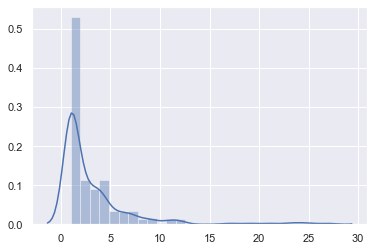

In [1025]:
sns.distplot(vocab_instances20_alltissue_df_btn_dist_stat['min'].values)

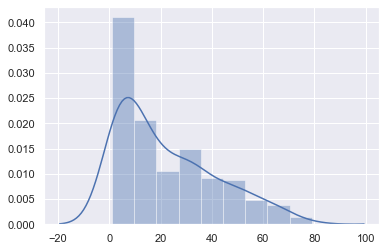

In [1026]:
sns.distplot(vocab_instances20_alltissue_df_btn_dist_stat['median'].values)

In [1459]:
# vocab length
print(pd.Series(vocab_instances20_alltissue_df.vocab1_stop-vocab_instances20_alltissue_df.vocab1_start).append(pd.Series(vocab_instances20_alltissue_df.vocab2_stop-vocab_instances20_alltissue_df.vocab2_start)).describe())
# vocab_instances20_alltissue_df_rs_filt[((vocab_instances20_alltissue_df_rs_filt.vocab1_stop-vocab_instances20_alltissue_df_rs_filt.vocab1_start)>=20)| ((vocab_instances20_alltissue_df_rs_filt.vocab2_stop-vocab_instances20_alltissue_df_rs_filt.vocab2_start)>=20)]#.vocab2.unique()
# vocab_instances20_alltissue_df_rs_filt[ ((vocab_instances20_alltissue_df_rs_filt.vocab2_stop-vocab_instances20_alltissue_df_rs_filt.vocab2_start)>=20)].vocab2.unique()


# really long tfs
vocab_instances20_alltissue_df_rs_filt[ ((vocab_instances20_alltissue_df_rs_filt.vocab1_stop-vocab_instances20_alltissue_df_rs_filt.vocab1_start)>=20)].vocab1.unique()



count    9172.000000
mean       10.907436
std         5.349342
min         3.000000
25%         6.000000
50%        10.000000
75%        14.000000
max        21.000000
dtype: float64


array(['THAP1', 'PATZ1', 'SP2', 'ZFP28', 'SP1', 'ZNF816', 'ZNF324', 'MAZ',
       'VEZF1'], dtype=object)

# 4. Add in positive and negative controls

need to run 8F_controls.ipynb first

In [1027]:
MAX_DIST

135

In [1028]:
tss_df = pd.read_csv('../data/external/TSS_annon_hg19.csv',index_col=0).drop_duplicates('TSS')
tss_df

,chr,loc,end,width,strand,TSS
0,chr1,1846266,1846266,1,*,CALML6
1,chr1,231376933,231376933,1,*,C1orf131
2,chr1,241683061,241683061,1,*,FH
3,chr1,120202421,120202421,1,*,PHGDH
4,chr1,204135465,204135465,1,*,REN
...,...,...,...,...,...,...
20255,chrX,140084756,140084756,1,*,SPANXB2
20256,chrX,52683950,52683950,1,*,SSX7
20257,chrX,140096761,140096761,1,*,SPANXB1
20258,chrX,52736239,52736239,1,*,SSX2


In [1029]:
# pos_genes_df = pd.read_csv(os.path.join(save_dir, 'pos_genes_df.csv'),index_col=0)#.gene.values#.iloc[:,0]
pos_genes_df = pd.read_csv(os.path.join(save_dir, 'all_pos_genes.csv'),header=None, index_col=0).index.values
pos_genes_df = pd.DataFrame.from_dict({'gene':pos_genes_df},orient='columns')
print('pos genes', pos_genes_df.shape)
neg_genes_df = pd.read_csv(os.path.join(save_dir, 'neg_genes_far.csv'),header=None, index_col=0).index.values
neg_genes_df = pd.DataFrame.from_dict({'gene':neg_genes_df},orient='columns')
print('neg genes', neg_genes_df.shape)


pos genes (85, 1)
neg genes (275, 1)


In [1030]:
pos_genes_df = pos_genes_df.merge(tss_df[['TSS','chr','end']], how='left',left_on='gene',right_on='TSS').dropna().drop_duplicates()
pos_genes_df['start'] = pos_genes_df.end - MAX_DIST
pos_genes_df = pos_genes_df[['chr','start','end','gene']].drop_duplicates().sort_values(['chr','start']).reset_index(drop=True)

pos_genes_df.shape

(85, 4)

In [1031]:
neg_genes_df = neg_genes_df.merge(tss_df[['TSS','chr','end']], how='left',left_on='gene',right_on='TSS').dropna().drop_duplicates()#.shape
neg_genes_df.end = neg_genes_df.end.map(int)
neg_genes_df['start'] = neg_genes_df.end - MAX_DIST
neg_genes_df = neg_genes_df[['chr','start','end','gene']].drop_duplicates().sort_values(['chr','start']).reset_index(drop=True)
neg_genes_df.shape

(95, 4)

In [1032]:
pos_genes_df.to_csv(os.path.join(save_dir, 'pos_genes_position.csv'))
neg_genes_df.to_csv(os.path.join(save_dir, 'neg_genes_position.csv'))

In [1232]:
pybedtools.BedTool.from_dataframe(pos_genes_df).sort().saveas(os.path.join(save_dir, 'pos_genes_position.bed'))
pybedtools.BedTool.from_dataframe(neg_genes_df).sort().saveas(os.path.join(save_dir, 'neg_genes_position.bed'))

<BedTool(../data/processed/fig4_modelling/vocab_sum_final/neg_genes_position.bed)>

# 4. get sequences

- vocab sequences in : `../data/processed/fig4_modelling/vocab_sum_final/vocab_instances20_alltissue_df.csv`
- pos sequences in: `../data/processed/fig4_modelling/vocab_sum_final/pos_genes_position.csv`
- neg sequences in : `../data/processed/fig4_modelling/vocab_sum_final/neg_genes_position.csv`

get sequence by url requesting http://genome.ucsc.edu/cgi-bin/das/hg19/dna?segment=chr1:100000,200000


## 4A get sequences

In [1037]:
import urllib.request
import xmltodict


In [1038]:
def get_sequence(row,chr_col='chr', start_col='start', stop_col='end'):
    url = 'http://genome.ucsc.edu/cgi-bin/das/hg19/dna?segment={}:{},{}'.format(row[chr_col],row[start_col],row[stop_col])#chr4:39355986,39356120'
    contents = urllib.request.urlopen(url).read()
    sequence = ''.join(xmltodict.parse(contents)['DASDNA']['SEQUENCE']['DNA']['#text'].upper().split('\n'))
    return(sequence)

In [1171]:
# #testing
# row = vocab_instances20_alltissue_df.loc[0,:]
# get_sequence(row,chr_col='chr', start_col='start_pad', stop_col='stop_pad')

In [1172]:
%%time
# probably will take ~20 min (12 min 35s for 15instances , 17 min for 20instances)
print(vocab_instances20_alltissue_df.shape)
vocab_instances20_alltissue_df['sequence'] = vocab_instances20_alltissue_df.apply(lambda x: get_sequence(x, chr_col='chr', start_col='start_pad', stop_col='stop_pad'),axis=1)

(4586, 18)
CPU times: user 4.72 s, sys: 1.51 s, total: 6.23 s
Wall time: 15min 45s


In [1173]:
%%time
# takes 18.3 s
print(pos_genes_df.shape)
pos_genes_df['sequence'] = pos_genes_df.apply(lambda x: get_sequence(x, chr_col='chr', start_col='start', stop_col='end'),axis=1)

(85, 6)
CPU times: user 81.4 ms, sys: 28.6 ms, total: 110 ms
Wall time: 16.5 s


In [1174]:
%%time
# takes 18.8 s
print(neg_genes_df.shape)
neg_genes_df['sequence'] = neg_genes_df.apply(lambda x: get_sequence(x, chr_col='chr', start_col='start', stop_col='end'),axis=1)

(95, 6)
CPU times: user 94.3 ms, sys: 32 ms, total: 126 ms
Wall time: 20.1 s


In [1175]:
vocab_instances20_alltissue_df.to_csv(os.path.join(save_dir, 'vocab_instances20_alltissue_df_wseq.csv'))
pos_genes_df.to_csv(os.path.join(save_dir, 'pos_genes_position_wseq.csv'))
neg_genes_df.to_csv(os.path.join(save_dir, 'pos_genes_position_wseq.csv'))

## 4B MPRA CONSTANTS (choosing RS)

In [154]:

# define constants
LEN_FILLER = 20
NUM_OLIGO_PER_MOTIF = 10
DESIRED_OLIGO_LENGTH = 150
MAX_OLIGO_LENGTH = 230
MAX_MOTIF_LENGTH = 63
FORWARD_PCR_PRIMER = 'ACTGGCCGCTTCACTG'
REVERSE_PCR_PRIMER = 'AGATCGGAAGAGCGTCG'
# LINKER_SPACER_v10 = 'CAGTATGCGATGCTCATGATTGTGACTGAAAGTCTATGAGTCCATTGA'
RS_ECORI = 'GAATTC' # 5'-3'
RS_BAMHI = 'GGATCC'
RS_XHOI = 'CTCGAG'
RS_XBAI = 'TCTAGA'
RS_BSPDI = 'ATCGAT'
RS_NHEI = 'GCTAGC'
RS_NCOI = 'CCATGG'

# CCTAGG formed by RS_XHOI and RS_NHEI, can be cut by AvrII

# RS_LIST = [RS_ECORI ,RS_BAMHI , RS_XHOI , RS_XBAI] #original
# RS_LIST = [RS_BSPDI ,RS_BAMHI , RS_XHOI, RS_NHEI]
RS_LIST = [RS_ECORI ,RS_BAMHI , RS_XHOI , RS_NHEI]

RS_XBAI_dam1 = 'GATCTAGA'
RS_XBAI_dam2 = 'TCTAGATC'
RS_XBAI_dam1_pre = '^GA'
RS_XBAI_dam2_suf = 'TC$'
LETTERS=['A', 'C', 'G', 'T']

## 4C check if the mpra restriction enzymes (and then remove sequences that don't pass rs checking

revision: replace XbaI with NcoI b/c dam methylation of Xba (NcoI pairs with XhoI, in the second restriction digest)

not if the restriction site is NOT the sequence area manually change the sequence

In [155]:

def check_rs(seq, rs_list = RS_LIST):
    rs_sites = 0
    for rs in rs_list:
        if rs in seq:
            rs_sites+=1
    return rs_sites

In [1183]:
vocab_instances20_alltissue_df['check_rs'] = vocab_instances20_alltissue_df.sequence.apply(check_rs)
vocab_instances20_alltissue_df[vocab_instances20_alltissue_df.check_rs>0].shape, vocab_instances20_alltissue_df.shape

((340, 20), (4586, 20))

In [1184]:
test = vocab_instances20_alltissue_df[vocab_instances20_alltissue_df.check_rs==0].vocab_pair.value_counts()
test[test<=10]

NFIC::RARG    10
CBFB::IRF8    10
Name: vocab_pair, dtype: int64

507 of the 4691 instances are bad . But only all vocab words have at least 10 genomic instances

In [1185]:
# controls
pos_genes_df['check_rs'] = pos_genes_df.sequence.apply(check_rs)
print(pos_genes_df[pos_genes_df.check_rs>0].shape, pos_genes_df.shape)

neg_genes_df['check_rs'] = neg_genes_df.sequence.apply(check_rs)
print(neg_genes_df[neg_genes_df.check_rs>0].shape, neg_genes_df.shape)

(13, 6) (85, 6)
(6, 6) (95, 6)


In [1186]:
# new dataframes
vocab_instances20_alltissue_df_rs_filt = vocab_instances20_alltissue_df[vocab_instances20_alltissue_df.check_rs==0]
pos_genes_df_rs_filt = pos_genes_df[pos_genes_df.check_rs==0]
neg_genes_df_rs_filt = neg_genes_df[neg_genes_df.check_rs==0]
print(vocab_instances20_alltissue_df_rs_filt.shape)
print(pos_genes_df_rs_filt.shape)
print(neg_genes_df_rs_filt.shape)
vocab_instances20_alltissue_df_rs_filt.to_csv(os.path.join(save_dir, 'vocab_instances20_alltissue_df_wseq_rsfilt.csv'))
pos_genes_df_rs_filt.to_csv(os.path.join(save_dir, 'pos_genes_position_wseq_rsfilt.csv'))
neg_genes_df_rs_filt.to_csv(os.path.join(save_dir, 'neg_genes_position_wseq_rsfilt.csv'))

(4246, 20)
(72, 6)
(89, 6)


In [1187]:
vocab_instances20_alltissue_df_rs_filt[['vocab_pair','chr','start_pad','stop_pad']].vocab_pair.value_counts()

BATF::KLF15       20
NFE2L1::ZBTB49    20
IRF8::STAT1       20
FOXL1::PRRX1      20
SP1::TBX1         20
                  ..
IRF4::PLAG1       12
IKZF1::IRF2       12
FOXM1::SP2        11
NFIC::RARG        10
CBFB::IRF8        10
Name: vocab_pair, Length: 239, dtype: int64

all vocab instances have at least 10 genomic sites

# 5. scramble sequences (vocab words)

test a max of `MAX_ITER` times, 

options:
- scramble only the motif
- scramble the 10 bp window around the motif

## 5A get the scrambles

In [161]:
vocab_instances20_alltissue_df_rs_filt = pd.read_csv(os.path.join(save_dir, 'vocab_instances20_alltissue_df_wseq_rsfilt.csv'),index_col=0)


In [162]:
vocab_instances20_alltissue_df_rs_filt.columns

Index(['vocab_pair', 'tot_dist', 'btn_dist', 'chr', 'start', 'stop', 'vocab1',
       'vocab1_start', 'vocab1_stop', 'vocab2', 'vocab2_start', 'vocab2_stop',
       'tissue', 'loop_type', 'start_pad', 'stop_pad', 'vocab_tissue_count',
       'name', 'sequence', 'check_rs'],
      dtype='object')

In [163]:
vocab_instances20_alltissue_df_rs_filt.sequence.apply(len).unique()

array([135])

In [164]:
vocab_instances20_alltissue_df_rs_filt[:5]

,vocab_pair,tot_dist,btn_dist,chr,start,stop,vocab1,vocab1_start,vocab1_stop,vocab2,vocab2_start,vocab2_stop,tissue,loop_type,start_pad,stop_pad,vocab_tissue_count,name,sequence,check_rs
0,BARX2::FOXF2,28,14,chr1,206848337,206848365,BARX2,206848337,206848341,FOXF2,206848355,206848365,Colon,pro_pro,206848284,206848418,1,BARX2::FOXF2+Colon+1,CTCAGCTCTCCCACAAGATCTCTGGGGAAGCTGGAAGAGGGCCACT...,0
1,BARX2::FOXF2,54,40,chr4,38859601,38859655,FOXF2,38859601,38859611,BARX2,38859651,38859655,Colon,loop_loop,38859561,38859695,2,BARX2::FOXF2+Colon+2,GTGGCTCTGAGGGAATTTCAAGTAACCGTGGACTAAAGTCTTAAGA...,0
2,BARX2::FOXF2,46,32,chr6,74222776,74222822,FOXF2,74222776,74222786,BARX2,74222818,74222822,Colon,loop_loop,74222732,74222866,3,BARX2::FOXF2+Colon+3,GCCACTGCACTCCAGCCTGGTGACAGAGCGAGACTCTGTCTCAAGA...,0
3,BARX2::FOXF2,16,2,chr3,49384674,49384690,FOXF2,49384674,49384684,BARX2,49384686,49384690,Colon,pro_pro,49384615,49384749,4,BARX2::FOXF2+Colon+4,AGTATTATGTGCTCATGGTCCCTACCCTCCAGGGTTCACAGTGTGG...,0
4,BARX2::FOXF2,16,2,chr10,112247520,112247536,BARX2,112247520,112247524,FOXF2,112247526,112247536,Colon,pro_pro,112247461,112247595,5,BARX2::FOXF2+Colon+5,ATGTGGCTGCGGGGCTTTAGGAGCTGACTCTTTGGTCACGGGGAGA...,0


In [165]:
# motif_bed = pybedtools.BedTool('../data/raw/merged_motif_scan/Colon_merged.bed')

In [166]:
# %%time
# motif_bed.to_dataframe()[:5]

In [167]:
row = vocab_instances20_alltissue_df_rs_filt.iloc[0,:]


In [168]:
# %%time
# pybedtools.BedTool.from_dataframe(pd.DataFrame(row[['chr','start_pad','stop_pad']]).T).intersect(motif_bed,wa=True,wb=True)

In [169]:
row

vocab_pair                                                 BARX2::FOXF2
tot_dist                                                             28
btn_dist                                                             14
chr                                                                chr1
start                                                         206848337
stop                                                          206848365
vocab1                                                            BARX2
vocab1_start                                                  206848337
vocab1_stop                                                   206848341
vocab2                                                            FOXF2
vocab2_start                                                  206848355
vocab2_stop                                                   206848365
tissue                                                            Colon
loop_type                                                       

In [170]:
glob.glob('../data/raw/merged_motif_scan/*')

['../data/raw/merged_motif_scan/COLO-SCR-DMSO_merged.bed',
 '../data/raw/merged_motif_scan/Icon\r',
 '../data/raw/merged_motif_scan/Renal_merged.bed',
 '../data/raw/merged_motif_scan/Prostate_merged.bed',
 '../data/raw/merged_motif_scan/Uterine_merged.bed',
 '../data/raw/merged_motif_scan/GDSD6_merged.bed',
 '../data/raw/merged_motif_scan/Pancreas_merged.bed',
 '../data/raw/merged_motif_scan/SCC13-CTRLi_merged.bed',
 '../data/raw/merged_motif_scan/Melanocytes_merged.bed',
 '../data/raw/merged_motif_scan/Ovarian_merged.bed',
 '../data/raw/merged_motif_scan/Bladder_merged.bed',
 '../data/raw/merged_motif_scan/GDSD3_merged.bed',
 '../data/raw/merged_motif_scan/Esophageal_merged.bed',
 '../data/raw/merged_motif_scan/A431-CTRLi_merged.bed',
 '../data/raw/merged_motif_scan/GM12878_merged.bed',
 '../data/raw/merged_motif_scan/Astrocytes_merged.bed',
 '../data/raw/merged_motif_scan/Colon_merged.bed',
 '../data/raw/merged_motif_scan/WM2664-SCR-DMSO_merged.bed',
 '../data/raw/merged_motif_scan/G

In [171]:
MAX_ITER = 10

In [189]:
from random import shuffle

def mixup(word):
    as_list_of_letters = list(word)
    shuffle(as_list_of_letters)
    return ''.join(as_list_of_letters)

def get_scrambles(row, motif_len_scr=10):
    # getting vocab locations in the sequence
    vocab1_med = int((row['vocab1_start']+row['vocab1_stop'])/2)
    vocab1_start_shift = vocab1_med - motif_len_scr - row['start_pad']
    vocab1_stop_shift = vocab1_med + motif_len_scr -row['start_pad'] + 1
    
    vocab2_med = int((row['vocab2_start']+row['vocab2_stop'])/2)
    vocab2_start_shift = vocab2_med - motif_len_scr - row['start_pad']
    vocab2_stop_shift = vocab2_med + motif_len_scr -row['start_pad'] + 1
    
    # for overlaps
    if vocab1_stop_shift>= vocab2_start_shift:
#         print(idx)
#         print(row)
        
        # case 1 vocab words are really close, the padding goes into the vocab word
        if (row['vocab1_stop']-row['start_pad'] + 1) >=vocab2_start_shift:
            
            vocab1_stop_shift = row['vocab1_stop']-row['start_pad'] + 1
            vocab2_start_shift = row['vocab1_stop']-row['start_pad'] + 1
#             print(vocab1_start_shift,vocab1_stop_shift, vocab2_start_shift, vocab2_stop_shift)
#             raise
        else: 
            vocab1_stop_shift = vocab1_stop_shift
            vocab2_start_shift = vocab1_stop_shift
#             print(vocab1_start_shift,vocab1_stop_shift, vocab2_start_shift, vocab2_stop_shift)
#             raise
    # for edges:
    vocab1_start_shift = max(0,vocab1_start_shift)
    vocab2_stop_shift = min(len(row['sequence']),vocab2_stop_shift)
    
    
    # get sequences
    vocab1_seq = row['sequence'][vocab1_start_shift:vocab1_stop_shift]
    vocab2_seq = row['sequence'][vocab2_start_shift:vocab2_stop_shift]

    vocab1_seq_scr = mixup(vocab1_seq)
    vocab2_seq_scr = mixup(vocab2_seq)

    A_B_seq = row['sequence']
    scrA_B_seq = row['sequence'][:vocab1_start_shift] + vocab1_seq_scr +  row['sequence'][vocab1_stop_shift:]
    A_scrB_seq = row['sequence'][:vocab2_start_shift] + vocab2_seq_scr +  row['sequence'][vocab2_stop_shift:]
    scrA_scrB_seq = row['sequence'][:vocab1_start_shift] + vocab1_seq_scr +  row['sequence'][vocab1_stop_shift:vocab2_start_shift] + vocab2_seq_scr +  row['sequence'][vocab2_stop_shift:]

    if len(scrA_scrB_seq)!=135:
        
        print(row)
        print(vocab1_start_shift, vocab1_stop_shift)
        print('vocab1_seq_scr',vocab1_seq_scr)
        print(vocab2_start_shift, vocab2_stop_shift)
        print('vocab2_seq_scr',vocab2_seq_scr)
        
        raise
#     if vocab1_stop_shift< vocab2_start_shift:
#         scrA_scrB_seq = row['sequence'][:vocab1_start_shift] + vocab1_seq_scr +  row['sequence'][vocab1_stop_shift:vocab2_start_shift] + vocab2_seq_scr +  row['sequence'][vocab2_stop_shift:]
#     else: # if the 10 bp windows for vocab1 and vocab2 overlap
#         vocab12_seq = row['sequence'][vocab1_start_shift:vocab2_stop_shift]
#         vocab12_seq_scr = mixup(vocab12_seq)
#         scrA_scrB_seq = row['sequence'][:vocab1_start_shift] + vocab12_seq_scr +  row['sequence'][vocab2_stop_shift:]
        

#     # FOR DEBUG
#     print(A_B_seq)
#     print(scrA_B_seq)
#     print(A_scrB_seq)
#     print(scrA_scrB_seq)

    return A_B_seq, scrA_B_seq, A_scrB_seq, scrA_scrB_seq

In [193]:
# ### tesin
# row = vocab_instances20_alltissue_df_rs_filt.iloc[100,:]
# print(row)
# motif_len_scr=10
# vocab1_med = int((row['vocab1_start']+row['vocab1_stop'])/2)
# vocab1_start_shift = vocab1_med - motif_len_scr - row['start_pad']
# vocab1_stop_shift = vocab1_med + motif_len_scr -row['start_pad'] + 1
# vocab2_med = int((row['vocab2_start']+row['vocab2_stop'])/2)
# vocab2_start_shift = vocab2_med - motif_len_scr - row['start_pad']
# vocab2_stop_shift = vocab2_med + motif_len_scr -row['start_pad'] + 1

# print(vocab1_start_shift,vocab1_stop_shift, vocab2_start_shift, vocab2_stop_shift)
# get_scrambles(row)

In [194]:
## iterate through the rows of the rs_filt vocab dataframe vocab_instances20_alltissue_df_rs_filt
print(vocab_instances20_alltissue_df_rs_filt.shape)
vocab_instances20_alltissue_df_rs_filt['scr_pass_rs'] = False
vocab_instances20_alltissue_df_rs_filt['A_B_seq'] = ''
vocab_instances20_alltissue_df_rs_filt['scrA_B_seq'] = ''
vocab_instances20_alltissue_df_rs_filt['A_scrB_seq'] = ''
vocab_instances20_alltissue_df_rs_filt['scrA_scrB_seq'] = ''

for idx, row in vocab_instances20_alltissue_df_rs_filt.iterrows():
    ## DEBUG
    if (idx%100)==0:
        print(idx)
    
    # set default
    scr_pass_rs = False
    num_iter = 0
    # iterate scrambles until find some that pass the check_rs filter
    while (not scr_pass_rs) ^ (num_iter > MAX_ITER):
        A_B_seq, scrA_B_seq, A_scrB_seq, scrA_scrB_seq = get_scrambles(row)



        # check_rs
        A_B_seq_rs = check_rs(A_B_seq)
        scrA_B_seq_rs = check_rs(scrA_B_seq)
        A_scrB_seq_rs = check_rs(A_scrB_seq)
        scrA_scrB_seq_rs = check_rs(scrA_scrB_seq)

        if (A_B_seq_rs+scrA_B_seq_rs+A_scrB_seq_rs+scrA_scrB_seq_rs==0):
            scr_pass_rs=True
        num_iter+=1
    
    # add information to df
    vocab_instances20_alltissue_df_rs_filt.at[idx, 'scr_pass_rs'] = scr_pass_rs
    vocab_instances20_alltissue_df_rs_filt.at[idx, 'A_B_seq'] = A_B_seq
    vocab_instances20_alltissue_df_rs_filt.at[idx, 'scrA_B_seq'] = scrA_B_seq
    vocab_instances20_alltissue_df_rs_filt.at[idx, 'A_scrB_seq'] = A_scrB_seq
    vocab_instances20_alltissue_df_rs_filt.at[idx, 'scrA_scrB_seq'] = scrA_scrB_seq
    



(4246, 25)
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200


In [195]:
# manual step
vocab_instances20_alltissue_df_rs_filt.scr_pass_rs.value_counts()

True    4246
Name: scr_pass_rs, dtype: int64

all sequences and scr configurations pass the rs filter

if they don't keep running the scrambling until they all pass

In [196]:
vocab_instances20_alltissue_df_rs_filt.reset_index(drop=True, inplace=True)
vocab_instances20_alltissue_df_rs_filt[ 'vocab_tissue_count'] = vocab_instances20_alltissue_df_rs_filt.groupby(['vocab_pair','tissue']).cumcount()+1
vocab_instances20_alltissue_df_rs_filt['name'] = vocab_instances20_alltissue_df_rs_filt.vocab_pair + '+'+ vocab_instances20_alltissue_df_rs_filt.tissue + '+'+ vocab_instances20_alltissue_df_rs_filt.vocab_tissue_count.map(str)
vocab_instances20_seqs = pd.melt(vocab_instances20_alltissue_df_rs_filt.drop('sequence',axis=1),
         id_vars=['vocab_pair', 'tot_dist', 'btn_dist', 'chr', 'start', 'stop', 'start_pad', 'stop_pad',
                  'vocab1','vocab1_start', 'vocab1_stop', 'vocab2', 'vocab2_start', 'vocab2_stop',
                  'tissue', 'loop_type',  'vocab_tissue_count','name','check_rs','scr_pass_rs'], 
            var_name='seq_config',
             value_name="seq")

vocab_instances20_seqs

,vocab_pair,tot_dist,btn_dist,chr,start,stop,start_pad,stop_pad,vocab1,vocab1_start,...,vocab2_start,vocab2_stop,tissue,loop_type,vocab_tissue_count,name,check_rs,scr_pass_rs,seq_config,seq
0,BARX2::FOXF2,28,14,chr1,206848337,206848365,206848284,206848418,BARX2,206848337,...,206848355,206848365,Colon,pro_pro,1,BARX2::FOXF2+Colon+1,0,True,A_B_seq,CTCAGCTCTCCCACAAGATCTCTGGGGAAGCTGGAAGAGGGCCACT...
1,BARX2::FOXF2,54,40,chr4,38859601,38859655,38859561,38859695,FOXF2,38859601,...,38859651,38859655,Colon,loop_loop,2,BARX2::FOXF2+Colon+2,0,True,A_B_seq,GTGGCTCTGAGGGAATTTCAAGTAACCGTGGACTAAAGTCTTAAGA...
2,BARX2::FOXF2,46,32,chr6,74222776,74222822,74222732,74222866,FOXF2,74222776,...,74222818,74222822,Colon,loop_loop,3,BARX2::FOXF2+Colon+3,0,True,A_B_seq,GCCACTGCACTCCAGCCTGGTGACAGAGCGAGACTCTGTCTCAAGA...
3,BARX2::FOXF2,16,2,chr3,49384674,49384690,49384615,49384749,FOXF2,49384674,...,49384686,49384690,Colon,pro_pro,4,BARX2::FOXF2+Colon+4,0,True,A_B_seq,AGTATTATGTGCTCATGGTCCCTACCCTCCAGGGTTCACAGTGTGG...
4,BARX2::FOXF2,16,2,chr10,112247520,112247536,112247461,112247595,BARX2,112247520,...,112247526,112247536,Colon,pro_pro,5,BARX2::FOXF2+Colon+5,0,True,A_B_seq,ATGTGGCTGCGGGGCTTTAGGAGCTGACTCTTTGGTCACGGGGAGA...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16979,STAT1::UBP1,28,7,chr2,65648057,65648085,65648004,65648138,UBP1,65648057,...,65648069,65648085,MM,loop_loop,16,STAT1::UBP1+MM+16,0,True,scrA_scrB_seq,AGAGATTTAAACATCATCATCTTGATTCCCAGTAACAACAATGCTG...
16980,STAT1::UBP1,32,14,chr1,24106333,24106365,24106282,24106416,UBP1,24106333,...,24106352,24106365,MM,pro_pro,17,STAT1::UBP1+MM+17,0,True,scrA_scrB_seq,TTGCCCAGGGTCACACAACTAAACAGGTATTCAAACTCAGGTTCCC...
16981,STAT1::UBP1,35,14,chr7,114551357,114551392,114551307,114551441,UBP1,114551357,...,114551376,114551392,MM,loop_loop,18,STAT1::UBP1+MM+18,0,True,scrA_scrB_seq,TCATTAGTGGGCTTTCAAAATACCAGCTTCTTGGTTACTGAGACAC...
16982,STAT1::UBP1,28,7,chr1,120178558,120178586,120178505,120178639,STAT1,120178558,...,120178581,120178586,MM,pro_pro,19,STAT1::UBP1+MM+19,0,True,scrA_scrB_seq,TCATATCACACTACGAAGAGAGCAACTAGAAGATATTATGCTCCTA...


In [197]:
vocab_instances20_seqs.seq.apply(len).unique()

array([135])

In [198]:
# save the vocab info
print(vocab_instances20_seqs.shape, vocab_instances20_alltissue_df_rs_filt.shape)
vocab_instances20_seqs.to_csv(os.path.join(save_dir, 'vocab_instances20_seq_wscr.csv'))

(16984, 22) (4246, 25)


In [199]:
vocab_instances20_seqs.columns


Index(['vocab_pair', 'tot_dist', 'btn_dist', 'chr', 'start', 'stop',
       'start_pad', 'stop_pad', 'vocab1', 'vocab1_start', 'vocab1_stop',
       'vocab2', 'vocab2_start', 'vocab2_stop', 'tissue', 'loop_type',
       'vocab_tissue_count', 'name', 'check_rs', 'scr_pass_rs', 'seq_config',
       'seq'],
      dtype='object')

## 5B only pick 10 best sequences (vocab) add the controls for final df


Input DFs:
- `vocab_instances20_seqs`: `vocab_instances20_seq_wscr.csv`
- `pos_genes_df_rs_filt`: `pos_genes_position_wseq_rsfilt.csv`
- `neg_genes_df_rs_filt`: `neg_genes_position_wseq_rsfilt.csv`

Output DF: 
- `mpra_lib_seq`: 'mpra_lib_seq.csv`

In [200]:
vocab_instances20_seqs[['vocab_pair','tissue']].drop_duplicates().shape

(239, 2)

still have 239 vocab words

In [201]:
vocab_instances20_seqs[vocab_instances20_seqs.vocab_tissue_count==10].vocab_pair.unique().shape

(239,)

all 239 vocab words have at least 10 genomic instances

In [202]:
vocab_instances20_seqs_sel[vocab_instances20_seqs_sel.seq.apply(len)!=135]

,vocab_pair,tot_dist,btn_dist,chr,start,stop,start_pad,stop_pad,vocab1,vocab1_start,...,vocab2_stop,tissue,loop_type,vocab_tissue_count,name,check_rs,scr_pass_rs,seq_config,seq,name_config
4413,FOXM1::SP2,131,110,chr16,68268437,68268568,68268435,68268569,SP2,68268437,...,68268568,Colon,loop_loop,8,FOXM1::SP2+Colon+8,0,True,scrA_B_seq,GCAGCCCCGCCTCCAGGTCTGACCAACCGAGGGGCAGAGAAACTCC...,FOXM1::SP2+Colon+8+scrA_B
4425,FOXM1::SP4,131,107,chr16,68268437,68268568,68268435,68268569,SP4,68268437,...,68268568,Colon,loop_loop,9,FOXM1::SP4+Colon+9,0,True,scrA_B_seq,GCAGCCCCGCCTCCAGGTCTGACCAACCGAGGGGCAGAGAAACTCC...,FOXM1::SP4+Colon+9+scrA_B
4624,KLF5::RUNX3,123,105,chr1,6259618,6259741,6259612,6259746,RUNX3,6259618,...,6259741,Colon,loop_loop,9,KLF5::RUNX3+Colon+9,0,True,scrA_B_seq,CCATACTAACCACAGGAGCCATGGCGGCAGCGGAGTTAGAAAGGGA...,KLF5::RUNX3+Colon+9+scrA_B
4625,KLF5::RUNX3,123,105,chr1,6259618,6259741,6259612,6259746,RUNX3,6259618,...,6259741,Colon,pro_pro,10,KLF5::RUNX3+Colon+10,0,True,scrA_B_seq,CCATACTAACCACAGGAGCCATGGCGGCAGCGGAGTTAGAAAGGGA...,KLF5::RUNX3+Colon+10+scrA_B
4734,MSX2::THAP1,121,95,chr11,102177000,102177121,102176993,102177127,MSX2,102177000,...,102177121,Colon,loop_loop,10,MSX2::THAP1+Colon+10,0,True,scrA_B_seq,AATGGTGAAATTAGTAATCATCCCAGCTGGTATAATACTGAATTGT...,MSX2::THAP1+Colon+10+scrA_B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14903,IRF8::ZNF816,128,106,chr9,134604524,134604652,134604521,134604655,ZNF816,134604524,...,134604652,GM12878,loop_loop,9,IRF8::ZNF816+GM12878+9,0,True,scrA_scrB_seq,CCCAGGGGCCATGAGGCAGGTCTCCCACCTCTCAGCTCAGGCTCAT...,IRF8::ZNF816+GM12878+9+scrA_scrB
14904,IRF8::ZNF816,134,101,chr22,39337645,39337779,39337645,39337779,IRF8,39337645,...,39337779,GM12878,loop_loop,10,IRF8::ZNF816+GM12878+10,0,True,scrA_scrB_seq,TGGTTTTAGTTCCTTGGGTGGTTTCCTCGGGGAACCACTATTTCTT...,IRF8::ZNF816+GM12878+10+scrA_scrB
15290,MITF::ZNF589,123,110,chr11,62446468,62446591,62446462,62446596,ZNF589,62446468,...,62446591,Melanocytes,loop_loop,1,MITF::ZNF589+Melanocytes+1,0,True,scrA_scrB_seq,GCGAGGCAACCCGCCCTCGACACCCGCCGACGGGCGCTCGCTCTCT...,MITF::ZNF589+Melanocytes+1+scrA_scrB
16351,EGR2::SOX10,127,109,chr9,38381691,38381818,38381687,38381821,EGR2,38381691,...,38381818,MM,loop_loop,8,EGR2::SOX10+MM+8,0,True,scrA_scrB_seq,AGGTGCCACCTCCACTCTGTCCTCACGGCCCTTGGCCTGGGACCCC...,EGR2::SOX10+MM+8+scrA_scrB


all vocab genomic i

In [203]:
vocab_instances20_seqs_sel[vocab_instances20_seqs_sel.vocab_pair.str.contains('FOX')]

,vocab_pair,tot_dist,btn_dist,chr,start,stop,start_pad,stop_pad,vocab1,vocab1_start,...,vocab2_stop,tissue,loop_type,vocab_tissue_count,name,check_rs,scr_pass_rs,seq_config,seq,name_config
0,BARX2::FOXF2,28,14,chr1,206848337,206848365,206848284,206848418,BARX2,206848337,...,206848365,Colon,pro_pro,1,BARX2::FOXF2+Colon+1,0,True,A_B_seq,CTCAGCTCTCCCACAAGATCTCTGGGGAAGCTGGAAGAGGGCCACT...,BARX2::FOXF2+Colon+1+A_B
1,BARX2::FOXF2,54,40,chr4,38859601,38859655,38859561,38859695,FOXF2,38859601,...,38859655,Colon,loop_loop,2,BARX2::FOXF2+Colon+2,0,True,A_B_seq,GTGGCTCTGAGGGAATTTCAAGTAACCGTGGACTAAAGTCTTAAGA...,BARX2::FOXF2+Colon+2+A_B
2,BARX2::FOXF2,46,32,chr6,74222776,74222822,74222732,74222866,FOXF2,74222776,...,74222822,Colon,loop_loop,3,BARX2::FOXF2+Colon+3,0,True,A_B_seq,GCCACTGCACTCCAGCCTGGTGACAGAGCGAGACTCTGTCTCAAGA...,BARX2::FOXF2+Colon+3+A_B
3,BARX2::FOXF2,16,2,chr3,49384674,49384690,49384615,49384749,FOXF2,49384674,...,49384690,Colon,pro_pro,4,BARX2::FOXF2+Colon+4,0,True,A_B_seq,AGTATTATGTGCTCATGGTCCCTACCCTCCAGGGTTCACAGTGTGG...,BARX2::FOXF2+Colon+4+A_B
4,BARX2::FOXF2,16,2,chr10,112247520,112247536,112247461,112247595,BARX2,112247520,...,112247536,Colon,pro_pro,5,BARX2::FOXF2+Colon+5,0,True,A_B_seq,ATGTGGCTGCGGGGCTTTAGGAGCTGACTCTTTGGTCACGGGGAGA...,BARX2::FOXF2+Colon+5+A_B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15125,FOXL1::PRRX1,33,13,chr17,45908368,45908401,45908317,45908451,PRRX1,45908368,...,45908401,Melanocytes,pro_pro,6,FOXL1::PRRX1+Melanocytes+6,0,True,scrA_scrB_seq,TTTAAATGAGCTAACACATATAAAAATAGTTATCACAGTGCCCTAT...,FOXL1::PRRX1+Melanocytes+6+scrA_scrB
15126,FOXL1::PRRX1,69,49,chr1,11322685,11322754,11322652,11322786,PRRX1,11322685,...,11322754,Melanocytes,pro_pro,7,FOXL1::PRRX1+Melanocytes+7,0,True,scrA_scrB_seq,TAGGGAGAAGATGGACTGAAAAACAACGGCGATAAAGAAAATGTGA...,FOXL1::PRRX1+Melanocytes+7+scrA_scrB
15127,FOXL1::PRRX1,22,2,chr16,84210876,84210898,84210820,84210954,PRRX1,84210876,...,84210898,Melanocytes,pro_pro,8,FOXL1::PRRX1+Melanocytes+8,0,True,scrA_scrB_seq,CAGTCTGAGCTGGAGCCCGTGCAGCCTCGGGCGGGGGCAGGCCTGG...,FOXL1::PRRX1+Melanocytes+8+scrA_scrB
15128,FOXL1::PRRX1,29,9,chrX,102820628,102820657,102820575,102820709,PRRX1,102820628,...,102820657,Melanocytes,pro_pro,9,FOXL1::PRRX1+Melanocytes+9,0,True,scrA_scrB_seq,TAAGAAGTCAGTGCTGTACTACAGCCACAGTTTTTTAAAATTAACT...,FOXL1::PRRX1+Melanocytes+9+scrA_scrB


### saving selection of vocab words
how `name_config` works:

`df['vocab_pair','tissue','vocab_tissue_count','seq_config'] = df.name_config.str.split('+',expand=True)`

In [210]:
# for rerunnin 
pos_genes_df_rs_filt = pd.read_csv(os.path.join(save_dir, 'pos_genes_position_wseq_rsfilt.csv'),index_col=0)
neg_genes_df_rs_filt = pd.read_csv(os.path.join(save_dir, 'neg_genes_position_wseq_rsfilt.csv'),index_col=0)

In [211]:
vocab_instances20_seqs_sel = vocab_instances20_seqs[vocab_instances20_seqs.vocab_tissue_count<=10]
vocab_instances20_seqs_sel['name_config'] = vocab_instances20_seqs_sel.name + '+' + vocab_instances20_seqs_sel.seq_config.str.split('_seq',expand=True).iloc[:,0]
print(vocab_instances20_seqs_sel.shape, vocab_instances20_seqs.shape)
vocab_instances20_seqs_sel.to_csv(os.path.join(save_dir, 'vocab_instances20_seq_wscr_sel.csv'))

/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(9560, 23) (16984, 22)


In [212]:
vocab_instances20_seqs_sel.columns

Index(['vocab_pair', 'tot_dist', 'btn_dist', 'chr', 'start', 'stop',
       'start_pad', 'stop_pad', 'vocab1', 'vocab1_start', 'vocab1_stop',
       'vocab2', 'vocab2_start', 'vocab2_stop', 'tissue', 'loop_type',
       'vocab_tissue_count', 'name', 'check_rs', 'scr_pass_rs', 'seq_config',
       'seq', 'name_config'],
      dtype='object')

In [213]:
vocab_instances20_seqs_sel.to_csv(os.path.join(save_dir, 'vocab_instances20_seqs_sel.csv'))

In [214]:
vocab_instances20_seqs_selcols = vocab_instances20_seqs_sel[['chr','start_pad','stop_pad','name_config','seq']]
vocab_instances20_seqs_selcols.columns = ['chr','start','stop','name','seq']
vocab_instances20_seqs_selcols['seq_type'] = 'vocab'

/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [215]:
pos_genes_df_seqs_sel_cols = pos_genes_df_rs_filt[['chr','start','end','gene','sequence']]
pos_genes_df_seqs_sel_cols.columns = ['chr','start','stop','name','seq']
pos_genes_df_seqs_sel_cols['seq_type'] = 'pos'
neg_genes_df_seqs_sel_cols = neg_genes_df_rs_filt[['chr','start','end','gene','sequence']]
neg_genes_df_seqs_sel_cols.columns = ['chr','start','stop','name','seq']
neg_genes_df_seqs_sel_cols['seq_type'] = 'neg'


In [216]:
mpra_lib_seq = pd.concat([vocab_instances20_seqs_selcols,pos_genes_df_seqs_sel_cols, neg_genes_df_seqs_sel_cols ],axis=0,sort=True)
mpra_lib_seq

,chr,name,seq,seq_type,start,stop
0,chr1,BARX2::FOXF2+Colon+1+A_B,CTCAGCTCTCCCACAAGATCTCTGGGGAAGCTGGAAGAGGGCCACT...,vocab,206848284,206848418
1,chr4,BARX2::FOXF2+Colon+2+A_B,GTGGCTCTGAGGGAATTTCAAGTAACCGTGGACTAAAGTCTTAAGA...,vocab,38859561,38859695
2,chr6,BARX2::FOXF2+Colon+3+A_B,GCCACTGCACTCCAGCCTGGTGACAGAGCGAGACTCTGTCTCAAGA...,vocab,74222732,74222866
3,chr3,BARX2::FOXF2+Colon+4+A_B,AGTATTATGTGCTCATGGTCCCTACCCTCCAGGGTTCACAGTGTGG...,vocab,49384615,49384749
4,chr10,BARX2::FOXF2+Colon+5+A_B,ATGTGGCTGCGGGGCTTTAGGAGCTGACTCTTTGGTCACGGGGAGA...,vocab,112247461,112247595
...,...,...,...,...,...,...
89,chrX,RHOXF2B,ACCACGCTCTCCTAGGCAGTGCTAGAACTGTGAGTCGCCGCCTGCA...,neg,119211572,119211707
90,chrX,CT47A12,AGTCTCTCTCTTTATTGAGGGAATAAGAGTCTGTCTCAGACGACAC...,neg,120066016,120066151
91,chrX,CT47A6,AGTCTCTCTCTTTATTGAGGGAATAAGAGTCTGTCTCAGACGACAC...,neg,120095202,120095337
92,chrX,SPANXN4,TGTCAGAGGTGGTTCTTTGTGATGCCAAAGCCACCCTAGGACTACC...,neg,142113569,142113704


#### some stats then saving

In [217]:
mpra_lib_seq.seq_type.value_counts()

vocab    9560
neg        89
pos        72
Name: seq_type, dtype: int64

In [218]:
vocab_instances20_seqs_sel.tissue.value_counts()/40

GDSD6          49.0
SCC            43.0
Colon          42.0
MM             40.0
GM12878        39.0
Melanocytes    26.0
Name: tissue, dtype: float64

In [220]:
vocab_instances20_seqs_sel.vocab_pair[vocab_instances20_seqs_sel.vocab_pair.isin(irf_vocab)].unique()

NameError: name 'irf_vocab' is not defined

In [1426]:
# number of vocab words that have irf vocab setup
vocab_instances20_seqs_sel.vocab_pair[vocab_instances20_seqs_sel.vocab_pair.isin(irf_vocab)].unique().shape


(19,)

In [221]:
mpra_lib_seq.to_csv(os.path.join(save_dir, 'mpra_lib_seq.csv'))

# 6. add MPRA adaptors and barcodes

done in 8E1R (based on `make_library_psych-postcadd-01119.ipynb` from the mpra library

note that the rs sites chosen from section 4B are: `[RS_ECORI ,RS_BAMHI , RS_XHOI , RS_NHEI]`

input is `../data/processed/fig4_modelling/vocab_sum_final/mpra_lib_seq.csv`

output is `../data/processed/fig4_modelling/vocab_sum_final/mpra_oligo_df_filt.csv`

In [222]:

# define constants
LEN_FILLER = 20
NUM_OLIGO_PER_MOTIF = 10
DESIRED_OLIGO_LENGTH = 135 #(changed from 150 )
MAX_OLIGO_LENGTH = 230
MAX_MOTIF_LENGTH = 63
FORWARD_PCR_PRIMER = 'ACTGGCCGCTTCACTG'
REVERSE_PCR_PRIMER = 'AGATCGGAAGAGCGTCG'
# LINKER_SPACER_v10 = 'CAGTATGCGATGCTCATGATTGTGACTGAAAGTCTATGAGTCCATTGA'
RS_ECORI = 'GAATTC' # 5'-3'
RS_BAMHI = 'GGATCC'
RS_XHOI = 'CTCGAG'
RS_NHEI = 'GCTAGC'


RS_LIST = [RS_ECORI ,RS_BAMHI , RS_XHOI , RS_NHEI]

LETTERS=['A', 'C', 'G', 'T']

# 7. MPRA final check 

- checks to make sure all sequences have 10 barcodes
- all rs sites are passed (done in R notebook)
- that there are still 239 vocab words with 40 instance (4 config of 10 each)

- `../data/processed/fig4_modelling/vocab_sum_final/mpra_lib_seq.csv` - includes information on all the sequences used
- `../data/processed/fig4_modelling/vocab_sum_final/mpra_oligo_df_filt.csv` - oligo information with a lot of columns (RS site check results etc.(
- `../data/processed/fig4_modelling/vocab_sum_final/mpra_oligo_df_final.txt` - with columns: name, seq_type, id, oligo, seq, filler, barcode
- `../data/processed/fig4_modelling/vocab_sum_final/mpra_oligo_df_final_SUBMIT.txt` - with columns: id, oligo

In [1436]:
glob.glob(os.path.join(save_dir))

['../data/processed/fig4_modelling/vocab_sum_final/']

In [226]:
oligo_df_filt = pd.read_csv(os.path.join(save_dir,'mpra_oligo_df_filt.csv'),index_col=0)
print(oligo_df_filt.shape)
oligo_df_filt[:5]

(97210, 21)


,name,seq,seq_type,count,id,pass_restrict_seq,pass_restrict_fwd_seq,pass_restrict_seq_xho,barcode,len_seq,...,1:n(),filler,filler_check,oligo,len_oligo,pass_restrict_ECORI,pass_restrict_BAMHI,pass_restrict_XHOI,pass_restrict_NHEI,pass_all
1,ABCF3,ACCTTGAGCTCCCAGCCTTTGCCCCACCCCTCGCTCCCGGAACTCC...,pos,1,ABCF3.1,True,True,True,GACCGGAGTAGGTTAGGTTA,136,...,8,CCGCCATTGTCTCGGGCGAA,True,ACTGGCCGCTTCACTGACCTTGAGCTCCCAGCCTTTGCCCCACCCC...,221,True,True,True,True,True
2,ABCF3,ACCTTGAGCTCCCAGCCTTTGCCCCACCCCTCGCTCCCGGAACTCC...,pos,2,ABCF3.2,True,True,True,GCTGGCGAATATAAGAGTAT,136,...,14,GCCCTATTATATGTGCGTCC,True,ACTGGCCGCTTCACTGACCTTGAGCTCCCAGCCTTTGCCCCACCCC...,221,True,True,True,True,True
3,ABCF3,ACCTTGAGCTCCCAGCCTTTGCCCCACCCCTCGCTCCCGGAACTCC...,pos,3,ABCF3.3,True,True,True,TGAGATCCAACCAAGGTTGC,136,...,5,ACAAGGTAGGAGGGGCAGAG,True,ACTGGCCGCTTCACTGACCTTGAGCTCCCAGCCTTTGCCCCACCCC...,221,True,True,True,True,True
4,ABCF3,ACCTTGAGCTCCCAGCCTTTGCCCCACCCCTCGCTCCCGGAACTCC...,pos,4,ABCF3.4,True,True,True,AAGATTAATCGGAGGAGTTG,136,...,1,CCTAAAATATGGACTTACCG,True,ACTGGCCGCTTCACTGACCTTGAGCTCCCAGCCTTTGCCCCACCCC...,221,True,True,True,True,True
5,ABCF3,ACCTTGAGCTCCCAGCCTTTGCCCCACCCCTCGCTCCCGGAACTCC...,pos,5,ABCF3.5,True,True,True,GAAGTACTCTCCTGCGAGGA,136,...,4,AGGACCTCCGTTGGCAATTC,True,ACTGGCCGCTTCACTGACCTTGAGCTCCCAGCCTTTGCCCCACCCC...,221,True,True,True,True,True


In [227]:
seq_counts = oligo_df_filt.name.value_counts()
seq_counts[seq_counts!=10]

Series([], Name: name, dtype: int64)

 all sequences have 10 barcodes


rs sites checks (done in R notebook)
- no EcoRI 
- no BamHI sites
- exactly 1 XhoI site
- exactly 1 NheI site


In [228]:
vocab_oligo_df =  oligo_df_filt[oligo_df_filt.seq_type=='vocab']
    
vocab_oligo_df[['vocab_pair','tissue','vocab_tissue_count','seq_config']]= vocab_oligo_df.name.str.split('+',expand=True)

/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [229]:
vocab_oligo_counts = vocab_oligo_df.vocab_pair.value_counts()
vocab_oligo_counts[vocab_oligo_counts!=400]

Series([], Name: vocab_pair, dtype: int64)

 all vocab types have 4 configs x 10 genomic instances x 10 barcodes = 400 oligos


In [230]:
vocab_oligo_counts.shape

(239,)

there are 239 vocab words

## 7B motif scan

### 1. make fasta 


In [231]:
fasta_file = os.path.join(save_dir, 'mpra_vocab_seq2.fasta')
print(vocab_oligo_df[['name','seq']].drop_duplicates().shape)
with open(fasta_file, 'w') as f:
    for idx, row in vocab_oligo_df[['name','seq']].drop_duplicates().iterrows():
        f.write('>'+row['name']+'\n')
        f.write(row['seq']+'\n')

(9560, 2)


,name,seq
1,ABCF3,ACCTTGAGCTCCCAGCCTTTGCCCCACCCCTCGCTCCCGGAACTCC...
11,ADM,GCTCCTCTCGGCTTTGCTCCGTCCCTGCCCCGGCCCCTCCGCGGGA...
21,ALDH16A1,ATAAATCCGGAGCCCTCCTAACTATTCGCAAAGTACCCACATCGCC...
31,ANAPC15,CTTACCGCGCCGGGAGGCTGCTGCCGGCGGCGACCCGGAAGCGCTT...
41,ANXA2,CCCAGCAGGGCTCTGACCTACCTGGGCAGCCTCATTCCCCCACATC...
...,...,...
97161,ZNF580,GAGTAGCAAGGTGCGCGACGCAGGAACCTTTCTCTTGTGGGTGCGT...
97171,ZNF581,GGGAGAAGGGGCTATTTCCCATGGGAAGACAAAGTGGGATGAATAG...
97181,ZNF679,CAGAAATATGCCACAATCCCCAATGGAGGCCAAGACAAGGCAAGTC...
97191,ZNF839,AACTGCGGAATCTTTTGGACTGGCCCAGAGGTTATCCAAGGCTACC...


In [323]:
fasta_control_file = os.path.join(save_dir, 'mpra_control_seq.fasta')
control_oligo_df = oligo_df_filt[oligo_df_filt.seq_type.isin(['pos','neg'])]
print(control_oligo_df[['name','seq']].drop_duplicates().shape)
with open(fasta_control_file, 'w') as f:
    for idx, row in control_oligo_df[['name','seq']].drop_duplicates().iterrows():
        f.write('>'+row['name']+'\n')
        f.write(row['seq']+'\n')

(161, 2)


In [339]:
fasta_neg_file = os.path.join(save_dir, 'mpra_neg_control_seq.fasta')
neg_control_oligo_df = oligo_df_filt[oligo_df_filt.seq_type.isin(['neg'])].sort_values('name')
print(neg_control_oligo_df[['name','seq']].drop_duplicates().shape)
with open(fasta_neg_file, 'w') as f:
    for idx, row in neg_control_oligo_df[['name','seq']].drop_duplicates().iterrows():
        f.write('>'+row['name']+'\n')
        f.write(row['seq']+'\n')

(89, 2)


In [341]:
fasta_pos_file = os.path.join(save_dir, 'mpra_pos_control_seq.fasta')
pos_control_oligo_df = oligo_df_filt[oligo_df_filt.seq_type.isin(['pos'])].sort_values('name')
print(pos_control_oligo_df[['name','seq']].drop_duplicates().shape)
with open(fasta_pos_file, 'w') as f:
    for idx, row in pos_control_oligo_df[['name','seq']].drop_duplicates().iterrows():
        f.write('>'+row['name']+'\n')
        f.write(row['seq']+'\n')

(72, 2)


### scanning try 1: RSAT FAILED


http://rsat.sb-roscoff.fr/matrix-scan.cgi



Server command
$RSAT/perl-scripts/matrix-scan -v 1   -quick -matrix_format transfac -m $RSAT/public_html/tmp/apache/2020/09/02/matrix-scan_2020-09-02.015859_5S2uJF.matrix -pseudo 1 -decimals 1 -2str -origin end -bginput -markov 1 -bg_pseudo 0.01 -return limits -return sites -lth score 1 -i $RSAT/public_html/tmp/apache/2020/09/02/tmp_sequence_2020-09-02.015859_VpAOG3.fasta -seq_format fasta -n score 

[RSAT] matrix-scan 2020-09-02.020844


Command: nice -n 19 $RSAT/perl-scripts/matrix-scan -v 1   -quick -matrix_format transfac -m $RSAT/public_html/tmp/apache/2020/09/02/matrix-scan_2020-09-02.020844_AC8494.matrix -pseudo 1 -decimals 1 -2str -origin end -bginput -markov 1 -bg_pseudo 0.01 -return limits -return sites -lth score 1 -i $RSAT/public_html/tmp/apache/2020/09/02/tmp_sequence_2020-09-02.020844_IedJeb.fasta -seq_format fasta -n score

Your task has been submitted to the RSAT server.

After completion of the task, an email will be sent to mguo123@stanford.edu

The result will become available at
	http://rsat.sb-roscoff.fr/tmp/apache/2020/09/02/matrix-scan_2020-09-02.020844_AC8494.ft


### scanning try 2: meme suite failed

also try http://meme-suite.org/info/status?service=MAST&id=appMAST_5.1.11599005652624-545759054
    
    Status Messages
Parsing arguments
Arguments ok
Starting mast
mast -oc . -nostatus -minseqs 9560 -ev 10.0 HOCOMOCOv11_core_HUMAN_mono_meme_format.meme sequences.fa





try: 
http://meme-suite.org/info/status?service=FIMO&id=appFIMO_5.1.11599763721265-808903115
`fimo --oc . --verbosity 1 --thresh 1.0E-4 motifs.meme mpra_vocab_seq2.fasta`

enter `../data/external/HOCOMOCOv11_core_HUMAN_mono_jaspar_format.txt`

### scanning try 3 MOODS package
https://github.com/jhkorhonen/MOODS/wiki/Getting-started
Matrices. The matrices are expected in the JASPAR .pfm format or the .adm format for first-order models. A JASPAR .pfm file consist of four rows, specifying the counts or frequencies for nucleotides A, C, G and T, respectively:

#### DESCRIPTION

MOODS 1.9.1 introduced a Python command-line script moods-dna.py for standalone PWM analysis using the MOODS algorithms. This section explains the basics of using `moods-dna.py`

#### Input matrics (motifs)
pfms are in `/Users/mguo123/Google Drive/1_khavari/omics_project-LD/pan_omics/data/external/hocomoco_human_trim`
Note: the extensions are pwm but are pfms

#### Input sequences
Sequences. The sequences can be given either as plain text files, or as fasta files possibly containing multiple sequences. Newlines and leading and trailing whitespace will be ignored, but other characters not encoding nucleotides will be treated as non-matchable positions (i.e., they should not appear outside fasta headers). IUPAC nucleotide ambiguity codes (WSMKRYBDHV) will be treated as coding SNPs, and MOODS will match the matrices versus all possible combinations.

#### Output (csv)
The comma-separated fields are:

- Sequence name (either file name or fasta header).
- Matrix file name.
- Hit position (first position of sequence is position 0).
- Indicates whether the match is versus the input strand (+) or the reverse complement (-).
- Match score.
- Hit site in the original sequence (note that if the match is -, then the match is versus the reverse complement of this).
- Hit sequence with SNPs applied, i.e. shows how the ambiguity codes are resolved to get this score (there can be multiple hits at the same position with different "real" hit sequences).


#### Installation 

follow: https://pypi.org/project/MOODS-python/

this doesn't work with subprocess
```
pip install --user MOODS-python
PATH="$PATH:`python -m site --user-base`/bin"
```

#### Basic usage
The basic usage pattern of `moods-dna.py` is the following:

```
moods-dna.py --help
usage: moods-dna.py [-h] [-v] [-m M [M ...]] [-S M [M ...]] [-s S [S ...]]
                    [-p p] [-t T] [-B n] [-o outfile] [--sep S] [-R]
                    [--no-snps] [--batch] [--bg pA pC pG pT] [--ps p]
                    [--log-base x] [--lo-bg pA pC pG pT]
                    [--threshold-precision x]

matches position weight matrices against DNA sequences

optional arguments:
  -h, --help            show this help message and exit
  -v, --verbosity       verbose (-vv, -vvv for more)

input files (at least one matrix and sequence file required):
  -m M [M ...], --matrices M [M ...]
                        matrix files (count/frequency, will be converted to
                        PWM before matching)
  -S M [M ...], --score-matrices M [M ...]
                        matrix files (PWM/other score matrix, will be matched
                        directly)
  -s S [S ...], --sequences S [S ...]
                        sequence files

threshold selection (exactly one required):
  -p p, --p-value p     compute threshold from p-value
  -t T, --threshold T   use specified absolute threshold
  -B n, --best-hits n   return at least the specified amount of best matches

output (optional):
  -o outfile, --outfile outfile
                        output to file instead of standard output
  --sep S               set field separator in out (default ",")

search and model behaviour (optional):
  -R, --no-rc           disable matching versus reverse complement strand
  --no-snps             ignore IUPAC symbols coding multiple nucleotides
  --batch               do not recompute thresholds from p-values for each
                        sequence separately (recommended when dealing with
                        lots of short sequences)
  --bg pA pC pG pT      background distribution for computing thresholds from
                        p-value with --batch (default is 0.25 for all alleles)
  --ps p                total pseudocount added to each matrix column in log-
                        odds conversion (default = 0.01)
  --log-base x          logarithm base for log-odds conversion (default
                        natural logarithm)
  --lo-bg pA pC pG pT   background distribution for log-odds conversion
                        (default is 0.25 for all alleles)
  --threshold-precision x
                        specify the precision used for computing the
                        thresholds from p-values (default = 2000.0)
                        
                        
moods-dna.py -m example-data/matrices/*.{pfm,adm} -s example-data/seq/chr1-5k-55k.fa -p 0.0001
moods-dna.py -m ../data/external/hocomoco_human_trim/*.pwm -s ../data/processed/fig4_modelling/vocab_sum_final/mpra_vocab_seq.fasta -p 0.0001

moods-dna.py -m ../data/external/hocomoco_human_trim/FOXM1_HUMAN.H11MO.0.A.pwm.trim.pwm -s ../data/processed/fig4_modelling/vocab_sum_final/mpra_vocab_seq.fasta -p 0.0001


```

In [1445]:
# # !pip install --user MOODS-python
# !PATH="$PATH:`python -m site --user-base`/bin"
# glob.glob(os.path.join(save_dir,"*fasta"))
import subprocess

In [325]:
# num actual tfs used 
list_tfs = sorted(set(list(vocab_instances20_alltissue_df_rs_filt.vocab1.unique()) + list(vocab_instances20_alltissue_df_rs_filt.vocab2.unique())))
len(list_tfs)

123

#### for vocab

In [1687]:
# make directory
motif_path = os.path.join(save_dir, 'motif_scan3') #../data/processed/fig4_modelling/vocab_sum_final/motif_scan3

if not os.path.exists(motif_path):
    os.makedirs(motif_path)
print(motif_path)

input_fasta = '../data/processed/fig4_modelling/vocab_sum_final/mpra_vocab_seq2.fasta'
# run_file = 'run_8E1_make_mpra_7_motif_scan.sh'
run_file = 'run_8E1_make_mpra_7_motif_scan_vocab_filt3.sh'

with open(run_file, 'w') as f:
# print(len(glob.glob('../data/external/hocomoco_human_trim/*pwm')))
    for pwm_file in sorted(glob.glob('../data/external/hocomoco_human_trim/*pwm')):
        pwm = os.path.basename(pwm_file).split('.pwm')[0]
        tf = tf_id_abbr_to_name_dict[pwm]
        if tf in list_tfs:
            output_file = os.path.join(motif_path, pwm+'_scan.csv')
#             cmd = 'moods-dna.py -m {} -s {} -p 0.00005 -o {}'.format(pwm_file,input_fasta, output_file) 
#             cmd = 'moods-dna.py -m {} -s {} -p 0.001 -o {}'.format(pwm_file,input_fasta, output_file) #motif_scan and motif_scan2 use this, the difference is in scrambling methods (see final analysis step)
            cmd = 'moods-dna.py -m {} -s {} -p 0.05 -o {}'.format(pwm_file,input_fasta, output_file) #motif_scan3 uses this, difference from motif_scan2 is the pvalue
            f.write(cmd+'\n')
        
# testing
# cmd = 'moods-dna.py -m {} -s {} -p 0.00005 -o {}'.format(pwm_file,input_fasta, output_file)
cmd = 'moods-dna.py -m {} -s {} -p 0.05 -o {}'.format(pwm_file,input_fasta, output_file)
print(cmd)
#moods-dna.py -m ../data/external/hocomoco_human_trim/ZSC31_HUMAN.H11MO.0.C.pwm.trim.pwm -s ../data/processed/fig4_modelling/vocab_sum_final/mpra_vocab_seq2.fasta -p 0.05 -o ../data/processed/fig4_modelling/vocab_sum_final/motif_scan3/ZN816_HUMAN.H11MO.1.C_scan.csv

# subprocess.Popen(cmd.split())

moods-dna.py -m ../data/external/hocomoco_human_trim/ZSC31_HUMAN.H11MO.0.C.pwm.trim.pwm -s ../data/processed/fig4_modelling/vocab_sum_final/mpra_vocab_seq2.fasta -p 0.05 -o ../data/processed/fig4_modelling/vocab_sum_final/motif_scan3/ZN816_HUMAN.H11MO.1.C_scan.csv


#### for controls

In [338]:
# make directory
# motif_path = os.path.join(save_dir, 'motif_scan_control')
motif_path = os.path.join(save_dir, 'motif_scan_control_pval001')

if not os.path.exists(motif_path):
    os.makedirs(motif_path)
print(motif_path)
input_fasta = '../data/processed/fig4_modelling/vocab_sum_final/mpra_control_seq.fasta'
run_file = 'run_8E1_make_mpra_7_motif_scan_control2.sh'

with open(run_file, 'w') as f:
# print(len(glob.glob('../data/external/hocomoco_human_trim/*pwm')))
    for pwm_file in sorted(glob.glob('../data/external/hocomoco_human_trim/*pwm')):
        pwm = os.path.basename(pwm_file).split('.pwm')[0]
        tf = tf_id_abbr_to_name_dict[pwm]
#         if tf in list_tfs:
        output_file = os.path.join(motif_path, pwm+'_scan.csv')
#         cmd = 'moods-dna.py -m {} -s {} -p 0.05 -o {}'.format(pwm_file,input_fasta, output_file) #motif_scan_control
        cmd = 'moods-dna.py -m {} -s {} -p 0.001 -o {}'.format(pwm_file,input_fasta, output_file) #motif_scan_control_pval001 
        f.write(cmd+'\n')
# testing
# cmd = 'moods-dna.py -m {} -s {} -p 0.00005 -o {}'.format(pwm_file,input_fasta, output_file)
cmd = 'moods-dna.py -m {} -s {} -p 0.05 -o {}'.format(pwm_file,input_fasta, output_file)
print(cmd)    

../data/processed/fig4_modelling/vocab_sum_final/motif_scan_control_pval001
moods-dna.py -m ../data/external/hocomoco_human_trim/ZSC31_HUMAN.H11MO.0.C.pwm.trim.pwm -s ../data/processed/fig4_modelling/vocab_sum_final/mpra_control_seq.fasta -p 0.05 -o ../data/processed/fig4_modelling/vocab_sum_final/motif_scan_control_pval001/ZSC31_HUMAN.H11MO.0.C_scan.csv


in cmd line in this folder run
`bash run_8E1_make_mpra_7_motif_scan_vocab_filt.sh`
`bash run_8E1_make_mpra_7_motif_scan_vocab_filt2.sh`
`bash run_8E1_make_mpra_7_motif_scan_vocab_filt3.sh`

in sherlock
```
cd /oak/stanford/groups/khavari/users/mguo123/pan_omics/notebooks

sbatch run_8E1_make_mpra_7_motif_scan_vocab_filt.sbatch



#!/bin/bash
#run_8E1_make_mpra_7_motif_scan.sbatch
#09/01/2020
#SBATCH -J motif_filt# A single job name for the array
#SBATCH -p rbaltman,khavari # Partition
#SBATCH -n 1 # one core
#SBATCH --mem=64000
#SBATCH --time=48:00:00
#SBATCH -o run_8E1_filt.out # Standard output
#SBATCH -e run_8E1_filt.err # Standard error
#SBATCH --mail-type=FAIL,END # notifications for job done & fail
#SBATCH --mail-user=mguo123@stanford.edu

cd /oak/stanford/groups/khavari/users/mguo123/pan_omics/notebooks

bash run_8E1_make_mpra_7_motif_scan_vocab_filt.sh

```

#### header of the `*_scan.csv`
   `ARID5B::KLF5+GDSD6+4+A_B,SRBP2_HUMAN.H11MO.0.B.pwm.trim.pwm,73,-,5.35564936116,CCACCCCGC,`
cvs headers (8 cols)
- vocabulary config name (from fasta)
- pwm filename
- position in the sequence (index 0)
- strand: Indicates whether the match is versus the input strand (+) or the reverse complement (-).
- score (bit score)
- sequence substring from what we are scanning (original sequence) (note that if the match is -, then the match is versus the reverse complement of this).
- (NOT USED)Hit sequence with SNPs applied, i.e. shows how the ambiguity codes are resolved to get this score (there can be multiple hits at the same position with different "real" hit sequences).


#### more on the score
    https://www.cs.helsinki.fi/group/pssmfind/doc/python/MOODS.html
      The input PWM matrix transformed to log-odds scores.
      The score for nucleotide N and position i is

         log ( matrix[N][i] + ps * bg[N] ) / C[i]
           - log ( bg[N] ),

      where C[i] is the sum of terms

         matrix[N][i] + ps * bg[N]

      for all nucleotides N.

    so all the matches to the PWM transformed log-odds score are summed to get the match score


In [1455]:
# x= vocab_instances20_alltissue_df_rs_filt[vocab_instances20_alltissue_df_rs_filt.name=='BARX2::FOXF2+Colon+1']
# x.start_pad - x.start    

In [ ]:
# vocab_oligo_df[vocab_oligo_df.name=='FLI1::FOXM1+Colon+9+A_B']
# vocab_instances20_alltissue_df_rs_filt[vocab_instances20_alltissue_df_rs_filt.name=='FLI1::FOXM1+Colon+9']

In [1454]:
vocab_instances20_alltissue_df_rs_filt[vocab_instances20_alltissue_df_rs_filt.name.str.contains('COT1')][:60]#.vocab_pair.unique()

,vocab_pair,tot_dist,btn_dist,chr,start,stop,vocab1,vocab1_start,vocab1_stop,vocab2,...,stop_pad,vocab_tissue_count,name,sequence,check_rs,scr_pass_rs,A_B_seq,scrA_B_seq,A_scrB_seq,scrA_scrB_seq


## 7C read in motif scan data 

cases for the motif in the 
1. scrambling removes motif 
2. there's a dummy motif somewhere else in the genomic instance (????? How would you deal with these “noisy” cases?
    2A. is the dummy motif is present in all 4 cases, (not changed by scrambling)
    2B. the dummy motif is present in only some cases, so probably changed by scrambling the other site?
3. scrambling reintroduces the motif at a (hopefully) lower strength, and sometimes with a shifted start position  ??? Potential to rescramble (but sometimes motifs have too many repetitive nucleotides so this might not work…
    3A. the scrambling introduces the motif at a lower strength
    3B. the scrambling does not lower the score of the motif
4. we don't detect the motif in any config in the genomic instance at a certain p value threshold (this usually isn’t the case, if we raise the p-value threshold enough; but the motif will be detected in a lot more genomic instances). This is sort of the sensitivity vs specificity tradeoff.


2 parts
1. map the vocab word locations to motifs and match to case above (get the score and the case) - exact match
2. determine vocab words gained lost between the motif configurations

### 7C1: get vocab_instance_df set up with locations and vocab predictions given config

In [4]:
# vocab_oligo_df.columns
vocab_instances20_seqs_sel = pd.read_csv(os.path.join(save_dir, 'vocab_instances20_seq_wscr_sel.csv'),index_col=0)
vocab_instances20_seqs_sel[:5]

,vocab_pair,tot_dist,btn_dist,chr,start,stop,start_pad,stop_pad,vocab1,vocab1_start,...,vocab2_stop,tissue,loop_type,vocab_tissue_count,name,check_rs,scr_pass_rs,seq_config,seq,name_config
0,BARX2::FOXF2,28,14,chr1,206848337,206848365,206848284,206848418,BARX2,206848337,...,206848365,Colon,pro_pro,1,BARX2::FOXF2+Colon+1,0,True,A_B_seq,CTCAGCTCTCCCACAAGATCTCTGGGGAAGCTGGAAGAGGGCCACT...,BARX2::FOXF2+Colon+1+A_B
1,BARX2::FOXF2,54,40,chr4,38859601,38859655,38859561,38859695,FOXF2,38859601,...,38859655,Colon,loop_loop,2,BARX2::FOXF2+Colon+2,0,True,A_B_seq,GTGGCTCTGAGGGAATTTCAAGTAACCGTGGACTAAAGTCTTAAGA...,BARX2::FOXF2+Colon+2+A_B
2,BARX2::FOXF2,46,32,chr6,74222776,74222822,74222732,74222866,FOXF2,74222776,...,74222822,Colon,loop_loop,3,BARX2::FOXF2+Colon+3,0,True,A_B_seq,GCCACTGCACTCCAGCCTGGTGACAGAGCGAGACTCTGTCTCAAGA...,BARX2::FOXF2+Colon+3+A_B
3,BARX2::FOXF2,16,2,chr3,49384674,49384690,49384615,49384749,FOXF2,49384674,...,49384690,Colon,pro_pro,4,BARX2::FOXF2+Colon+4,0,True,A_B_seq,AGTATTATGTGCTCATGGTCCCTACCCTCCAGGGTTCACAGTGTGG...,BARX2::FOXF2+Colon+4+A_B
4,BARX2::FOXF2,16,2,chr10,112247520,112247536,112247461,112247595,BARX2,112247520,...,112247536,Colon,pro_pro,5,BARX2::FOXF2+Colon+5,0,True,A_B_seq,ATGTGGCTGCGGGGCTTTAGGAGCTGACTCTTTGGTCACGGGGAGA...,BARX2::FOXF2+Colon+5+A_B


In [5]:
def vocab_present_func(row):
    # determine if there should be a vocab present (based on configuration)
    return row['vocab_order'] in row['config'].split('_')
#     vocab_instances_df.vocab_order.apply(lambda x: xisin(vocab_instances_df.config.str.split('_'))

In [6]:
vocab_instances_df = vocab_instances20_seqs_sel[['name_config','chr','start_pad','stop_pad','vocab1','vocab1_start','vocab1_stop']]
vocab_instances_df.columns = ['name_config','chr','start_pad','stop_pad','vocab','vocab_start','vocab_stop']
vocab_instances_df['vocab_order'] = 'A'

vocab_instances_df2 = vocab_instances20_seqs_sel[['name_config','chr','start_pad','stop_pad','vocab2','vocab2_start','vocab2_stop']]
vocab_instances_df2.columns = ['name_config','chr','start_pad','stop_pad','vocab','vocab_start','vocab_stop']
vocab_instances_df2['vocab_order'] = 'B'
vocab_instances_df = pd.concat([vocab_instances_df,vocab_instances_df2],axis=0,sort=True)
vocab_instances_df['instance'] = vocab_instances_df.name_config.apply(lambda x: '+'.join(x.split('+')[:-1]))
vocab_instances_df['config'] = vocab_instances_df.name_config.str.split('+',expand=True).iloc[:,-1]
vocab_instances_df['vocab_present_pred'] = vocab_instances_df.apply(vocab_present_func,axis=1)
vocab_instances_df['vocab_loc_start'] = vocab_instances_df.vocab_start - vocab_instances_df.start_pad
vocab_instances_df['vocab_loc_stop'] = vocab_instances_df.vocab_stop - vocab_instances_df.start_pad
vocab_instances_df.sort_values('name_config',inplace=True)
vocab_instances_df

/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,chr,name_config,start_pad,stop_pad,vocab,vocab_order,vocab_start,vocab_stop,instance,config,vocab_present_pred,vocab_loc_start,vocab_loc_stop
744,chr18,ARID5B::KLF5+GDSD6+1+A_B,61243074,61243208,ARID5B,A,61243131,61243135,ARID5B::KLF5+GDSD6+1,A_B,True,57,61
744,chr18,ARID5B::KLF5+GDSD6+1+A_B,61243074,61243208,KLF5,B,61243141,61243152,ARID5B::KLF5+GDSD6+1,A_B,True,67,78
9236,chr18,ARID5B::KLF5+GDSD6+1+A_scrB,61243074,61243208,ARID5B,A,61243131,61243135,ARID5B::KLF5+GDSD6+1,A_scrB,True,57,61
9236,chr18,ARID5B::KLF5+GDSD6+1+A_scrB,61243074,61243208,KLF5,B,61243141,61243152,ARID5B::KLF5+GDSD6+1,A_scrB,False,67,78
4990,chr18,ARID5B::KLF5+GDSD6+1+scrA_B,61243074,61243208,KLF5,B,61243141,61243152,ARID5B::KLF5+GDSD6+1,scrA_B,True,67,78
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11996,chr7,ZFX::E2F6+SCC+9+A_scrB,44153033,44153167,E2F6,A,44153086,44153095,ZFX::E2F6+SCC+9,A_scrB,True,53,62
7750,chr7,ZFX::E2F6+SCC+9+scrA_B,44153033,44153167,E2F6,A,44153086,44153095,ZFX::E2F6+SCC+9,scrA_B,False,53,62
7750,chr7,ZFX::E2F6+SCC+9+scrA_B,44153033,44153167,ZFX,B,44153101,44153114,ZFX::E2F6+SCC+9,scrA_B,True,68,81
16242,chr7,ZFX::E2F6+SCC+9+scrA_scrB,44153033,44153167,ZFX,B,44153101,44153114,ZFX::E2F6+SCC+9,scrA_scrB,False,68,81


In [7]:
vocab_instances_df.instance.unique().shape

(2390,)

### 7C2: add in motif_scan information per case

In [328]:
# helper functions
def label_config(row):
    if row['vocab_present_actual']: 
        if row['vocab_present_pred']:
            return 'TP' # good, Case 1
        else:
            return 'FP' # noisy, Case 3
    else:
        if row['vocab_present_pred']:
            return 'FN' # not detected (Case 4)
        else:
            return 'TN' # good, Case 1
def get_case_instance(row):
    row_counts = row.value_counts()
    # case 1: all the configs that should have the vocab have the vocab and those that don't do not
    if (row_counts.get('TP',0) +row_counts.get('TN',0) )==4:
        return 'case 1'
    # case 4: the pvalue threshold was too stringent
    elif (row_counts.get('FN',0) +row_counts.get('TN',0) )==4:
        return 'case 4'
    # case 3: too noisy
    elif (row_counts.get('TP',0) +row_counts.get('FP',0) )==4:
        return 'case 3'
    else:
        return 'other'

def analyze_motif_scan(motif_scan_file, tf_id_abbr_to_name_dict=tf_id_abbr_to_name_dict):
    # read in motif scan file
    motif_scan_results = pd.read_csv(motif_scan_file,names=['name_config','pwm_file','pos','strand','score','seq','seq_actual'])
    motif = tf_id_abbr_to_name_dict[os.path.basename(motif_scan_file).split('_scan')[0]]
    motif_scan_results['motif'] = motif_scan_results.pwm_file.str.split('.pwm',expand=True).iloc[:,0].map(tf_id_abbr_to_name_dict)

    # merge in genomic location information
    vocab_motif_scan = vocab_instances_df[vocab_instances_df.vocab==motif].merge( motif_scan_results[['name_config','pos','score','motif']], how='left',left_on=['name_config','vocab'], right_on=['name_config','motif'])
    vocab_motif_scan.pos.fillna(-1.0, inplace=True)
    vocab_motif_scan.score.fillna(0, inplace=True)
    vocab_motif_scan.motif.fillna('', inplace=True)
    vocab_motif_scan['vocab_present_actual'] = abs(vocab_motif_scan.vocab_loc_start - vocab_motif_scan.pos ) <=3
    vocab_motif_scan['off_target']  =  ~( ( vocab_motif_scan.vocab_present_actual) | (vocab_motif_scan.pos<0))

    #### case 2: off-target effects
    vocab_motif_scan_off_target = vocab_motif_scan[vocab_motif_scan.off_target]
    vocab_motif_scan_off_target.sort_values('score',ascending=False,inplace=True)
    vocab_motif_scan_off_target.drop_duplicates('name_config',inplace=True)
    vocab_motif_scan_off_target.sort_values('name_config',inplace=True)
    vocab_motif_scan_off_target['pos_close'] = vocab_motif_scan_off_target.pos - (vocab_motif_scan_off_target.pos%2)
    off_target_counts_df = pd.DataFrame(vocab_motif_scan_off_target.groupby('instance').pos_close.value_counts())
    off_target_counts_df.columns = ['count_pos']
    off_target_counts_df['motif'] = motif
    off_target_counts_df['case'] = off_target_counts_df.count_pos.apply(lambda x: 'case 2A' if x==4 else 'case 2B')
    off_target_counts_df.reset_index(inplace=True)

    ##### Case 1,3,4
    # - case 1: good
    # - case 3: FP (too noisy, scrambling might not be good), case 4: FN (pval, threshold too low )

    # only include the highest scoring 
    vocab_motif_scan_on_target = vocab_motif_scan[~vocab_motif_scan.off_target]
    vocab_motif_scan_on_target.sort_values('score',ascending=False,inplace=True)
    vocab_motif_scan_on_target.drop_duplicates('name_config',inplace=True)
    vocab_motif_scan_on_target.sort_values('name_config',inplace=True)

    # fill in all possible instances in the library
    vocab_motif_scan_on_target = vocab_instances_df[vocab_instances_df.vocab==motif].merge(vocab_motif_scan_on_target,how='left',on=list(vocab_instances_df.columns.values))
    vocab_motif_scan_on_target.pos.fillna(-1.0, inplace=True)
    vocab_motif_scan_on_target.score.fillna(0, inplace=True)
    vocab_motif_scan_on_target.motif.fillna('', inplace=True)
    vocab_motif_scan_on_target.vocab_present_actual.fillna(False, inplace=True)
    vocab_motif_scan_on_target.off_target.fillna(False, inplace=True)
    vocab_motif_scan_on_target['eval'] = vocab_motif_scan_on_target.apply(label_config, axis=1)

    # create data frame thats has rows (instances) and columns are the eval (TP,FP, etc) and score per config
    vocab_motif_scan_on_target_config = vocab_motif_scan_on_target.pivot(index='instance', columns='config', values=['eval','score'])
    vocab_motif_scan_on_target_config.columns = ['_'.join(list(x)) for x in vocab_motif_scan_on_target_config.columns.values]
    vocab_motif_scan_on_target_config['motif'] = motif
    vocab_motif_scan_on_target_config['case'] = vocab_motif_scan_on_target_config.apply(get_case_instance,axis=1)

    # dict of case_type: # instances that fall in type
    on_target_config_cases = vocab_motif_scan_on_target_config.case.value_counts()

    return motif, off_target_counts_df, vocab_motif_scan_on_target_config, on_target_config_cases

def analyze_motif_scan_wrap(motif_scan_files, save_prefix=None):
    print('# motif files: ', len(motif_scan_files))
    # overall dataframe setup
    off_target_counts_df_all = pd.DataFrame()
    on_target_cases_df_all = pd.DataFrame()
    on_target_config_cases_dict = {}
    
    #get scan results from file
    for idx,motif_scan_file in enumerate(motif_scan_files):
        ## DEBUG
    #     print(idx,motif_scan_file)
        motif, off_target_counts_df, vocab_motif_scan_on_target_config, on_target_config_cases = analyze_motif_scan(motif_scan_file)
        # ADD TO RUNNING LIST (ACROSS MOTIFS)
        off_target_counts_df_all = pd.concat([off_target_counts_df_all, off_target_counts_df],axis=0,sort=True)
        on_target_cases_df_all = pd.concat([on_target_cases_df_all, vocab_motif_scan_on_target_config],axis=0,sort=True)
        on_target_config_cases_dict[motif] = on_target_config_cases

    # convert dict to dataframe (row: motif, columns case type)
    on_target_config_cases_df = pd.DataFrame.from_dict(on_target_config_cases_dict,orient='index').fillna(0)

    ## TODO: add in save functionality
    if save_prefix is not None:
        off_target_counts_df_all.to_csv(save_prefix+'off_target_counts_df_all.csv')
        on_target_cases_df_all.to_csv(save_prefix+'motif_scan_'+'on_target_cases_df_all.csv')
        on_target_config_cases_df.to_csv(save_prefix+ 'motif_scan_'+'on_target_config_cases_df.csv')
        print('saved', save_prefix+'*.csv')
    return off_target_counts_df_all, on_target_cases_df_all, on_target_config_cases_df

def refine_case3(row):
    if row['case']!='case 3':
#         print(row['case'])
        return row['case']
    else:
        # only remodify case 3:
        if row['score_A_B']> min(row['score_A_scrB'],row['score_scrA_B'] ):
    #         print('here')
            return 'case 3A' # this is the good case where scrambling reduces the score of the motif
        else:
            return 'case 3B'
        # case 3, where the TP are have higher score than where the true negatives are

def get_offtarget_num(off_target_counts_df, vocab_instances_df=vocab_instances20_seqs_sel):
    off_target_res_case_2A = off_target_counts_df[off_target_counts_df.case=='case 2A']
    print(off_target_res_case_2A.shape)
    off_target_res_case_2A['off_target_pos_str'] = off_target_res_case_2A.pos_close.map(int).map(str)
    off_target_res_case_2A = off_target_res_case_2A.groupby(['instance','motif']).agg({'off_target_pos_str':'|'.join}).reset_index()
    off_target_res_case_2A.columns = ['off_target_name','off_target_motif','off_target_pos_str']
    print(off_target_res_case_2A.shape) # groupbed by instance
    vocab_instances20_seqs_sel_offtarget = vocab_instances_df.merge(off_target_res_case_2A, how='left',left_on='name',right_on='off_target_name')
    vocab_instances20_seqs_sel_offtarget.off_target_name.fillna('',inplace=True)
    vocab_instances20_seqs_sel_offtarget.off_target_motif.fillna('',inplace=True)
    vocab_instances20_seqs_sel_offtarget.off_target_pos_str.fillna('',inplace=True)
    vocab_instances20_seqs_sel_offtarget = pd.concat([vocab_instances20_seqs_sel_offtarget,vocab_instances20_seqs_sel_offtarget.apply(get_vocab_loc,axis=1)],axis=1)
    
#     return vocab_instances20_seqs_sel_offtarget
    vocab_instances20_seqs_sel_offtarget = vocab_instances20_seqs_sel_offtarget.groupby(['vocab_pair', 'tot_dist', 'btn_dist', 'chr', 'start', 'stop',
           'start_pad', 'stop_pad', 'vocab1', 'vocab1_start', 'vocab1_stop',
           'vocab2', 'vocab2_start', 'vocab2_stop', 'tissue', 'loop_type', 'name', 'check_rs', 'scr_pass_rs', 
           'vocab_tissue_count', 'seq_config', 'seq','name_config', 'off_target_name','vocab1_start_shift', 'vocab1_stop_shift',
           'vocab2_start_shift', 'vocab2_stop_shift']).agg({'off_target_motif':'::'.join,'off_target_pos_str':'::'.join}).reset_index()

    vocab_instances20_seqs_sel_offtarget = vocab_instances20_seqs_sel_offtarget.groupby(['vocab_pair', 'tot_dist', 'btn_dist', 'chr', 'start', 'stop',
           'start_pad', 'stop_pad', 'vocab1', 'vocab1_start', 'vocab1_stop',
           'vocab2', 'vocab2_start', 'vocab2_stop', 'tissue', 'loop_type', 'name',
           'check_rs', 'scr_pass_rs', 'vocab_tissue_count',  'vocab1_start_shift',
           'vocab1_stop_shift', 'vocab2_start_shift', 'vocab2_stop_shift','off_target_name',
           'off_target_motif', 'off_target_pos_str']).agg({'seq_config':list,'seq':list, 'name_config':list}).reset_index()
    # 


    off_target_num_df = pd.DataFrame(vocab_instances20_seqs_sel_offtarget.set_index('name').off_target_pos_str.apply(off_target_pos_str_find_num)).reset_index()
    off_target_num_df['instance'] = off_target_num_df.name.apply(lambda x: '+'.join(x.split('+')[:-1]))
    off_target_num_df_counts = off_target_num_df[off_target_num_df.off_target_pos_str==0].instance.value_counts().value_counts().sort_index()
    print(off_target_num_df_counts/off_target_num_df_counts.sum())
    return off_target_num_df[off_target_num_df.off_target_pos_str==0].instance.value_counts().describe()


def get_vocab_loc(row, motif_len_scr=10):
    # getting vocab locations in the sequence
    vocab1_med = int((row['vocab1_start']+row['vocab1_stop'])/2)
    vocab1_start_shift = vocab1_med - motif_len_scr - row['start_pad']
    vocab1_stop_shift = vocab1_med + motif_len_scr -row['start_pad'] + 1
    
    vocab2_med = int((row['vocab2_start']+row['vocab2_stop'])/2)
    vocab2_start_shift = vocab2_med - motif_len_scr - row['start_pad']
    vocab2_stop_shift = vocab2_med + motif_len_scr -row['start_pad'] + 1
    
    # for overlaps
    if vocab1_stop_shift>= vocab2_start_shift:
#         print(idx)
#         print(row)
        
        # case 1 vocab words are really close, the padding goes into the vocab word
        if (row['vocab1_stop']-row['start_pad'] + 1) >=vocab2_start_shift:
            
            vocab1_stop_shift = row['vocab1_stop']-row['start_pad'] + 1
            vocab2_start_shift = row['vocab1_stop']-row['start_pad'] + 1
#             print(vocab1_start_shift,vocab1_stop_shift, vocab2_start_shift, vocab2_stop_shift)
#             raise
        else: 
            vocab1_stop_shift = vocab1_stop_shift
            vocab2_start_shift = vocab1_stop_shift
#             print(vocab1_start_shift,vocab1_stop_shift, vocab2_start_shift, vocab2_stop_shift)
#             raise

    # for edges:
    vocab1_start_shift = max(0,vocab1_start_shift)
    vocab2_stop_shift = min(len(row['seq']),vocab2_stop_shift)
    
    return pd.Series({'vocab1_start_shift': vocab1_start_shift,
                      'vocab1_stop_shift':vocab1_stop_shift, 
                      'vocab2_start_shift':vocab2_start_shift, 
                      'vocab2_stop_shift':vocab2_stop_shift})


def get_vocab_to_loc_dict(row):
    return {row['vocab1']:[row['vocab1_start_shift'],row['vocab1_stop_shift']],
           row['vocab2']:[row['vocab2_start_shift'],row['vocab2_stop_shift']]}


def off_target_pos_str_find_num(pos_str):
    pos_arr_per_vocab_word = pos_str.split('::')
    if len(pos_arr_per_vocab_word)>0:
        arr = []
        for pos in pos_arr_per_vocab_word:
            for x in pos.split(':'):
                try:
                    arr.append(int(x))
                except:
                    continue
        return len(set(arr))
    return 0

def on_target_new_cases(row):
    motif_arr = row['motif'].split('|')
    case_mod_arr = row['case_mod'].split('|')
    num_motifs = len(set(motif_arr))
    if num_motifs>2:
        return '|'.join(sorted(set(motif_arr))), 'more than 2 motifs'
    elif num_motifs<2:
        return '|'.join(sorted(set(motif_arr))), 'less than 2 motifs'    
    else:
        motif_to_case = {}
        for motif, case in zip(motif_arr, case_mod_arr):
            if motif in motif_to_case:
                if (motif_to_case[motif]!='case 3A') & (motif_to_case[motif]!='case 1'):
                    motif_to_case[motif]=case
            else:
                motif_to_case[motif]=case
        motif_new = '|'.join(list(motif_to_case.keys()))
        case_new = '|'.join(list(motif_to_case.values()))
        return motif_new, case_new
    
def on_target_new_case_good(case_new):
    if '|' not in case_new:
        return False # not two motifs
    else:
        case_status = True
        for case in case_new.split('|'):
            if  (case!='case 3A') & (case!='case 1') :
                case_status = False
        return case_status
    
def get_on_target_good_instance_num(on_target_cases_df):
    on_target_counts = on_target_cases_df.reset_index()[['instance','motif','case_mod']].drop_duplicates().groupby('instance').agg({
    'motif':'|'.join, 'case_mod':'|'.join
    }).reset_index()
    on_target_counts['name'] = on_target_counts.instance.apply(lambda x: '+'.join(x.split('+')[:-1]))
    on_target_counts = pd.concat([on_target_counts, on_target_counts.apply(on_target_new_cases,axis=1).apply(lambda s: pd.Series({'motif_new':s[0], 'case_new':s[1]}))],axis=1)
    on_target_counts['case_good_bool'] = on_target_counts.case_new.apply(on_target_new_case_good)
    return on_target_counts[on_target_counts.case_good_bool==True].name.value_counts().describe()

In [257]:
# testing
    # read in motif scan file
motif_scan_results = pd.read_csv(motif_scan_files1[0],names=['name_config','pwm_file','pos','strand','score','seq','seq_actual'])
motif = tf_id_abbr_to_name_dict[os.path.basename(motif_scan_files1[0]).split('_scan')[0]]
motif_scan_results['motif'] = motif_scan_results.pwm_file.str.split('.pwm',expand=True).iloc[:,0].map(tf_id_abbr_to_name_dict)

# merge in genomic location information
vocab_motif_scan = vocab_instances_df[vocab_instances_df.vocab==motif].merge( motif_scan_results[['name_config','pos','score','motif']], how='left',left_on=['name_config','vocab'], right_on=['name_config','motif'])
vocab_motif_scan.pos.fillna(-1.0, inplace=True)
vocab_motif_scan.score.fillna(0, inplace=True)
vocab_motif_scan.motif.fillna('', inplace=True)
vocab_motif_scan['vocab_present_actual'] = abs(vocab_motif_scan.vocab_loc_start - vocab_motif_scan.pos ) <=3
vocab_motif_scan['off_target']  =  ~( ( vocab_motif_scan.vocab_present_actual) | (vocab_motif_scan.pos<0))



In [258]:
# vocab_motif_scan_off_target

#### version 1: analyze the original scrambled version (only scramble the motifs)

In [105]:
%%time
# takes ~ 15s

motif_scan_files1 = sorted(glob.glob(os.path.join(save_dir, 'motif_scan','*csv')))
off_target_counts_df_all_1, on_target_cases_df_all_1, on_target_config_cases_df_1 = analyze_motif_scan_wrap(motif_scan_files1, save_prefix=os.path.join(save_dir, 'motif_scan_'))
on_target_config_cases_df_1.sum(axis=0)

# motif files:  158


/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/ipyk

saved ../data/processed/fig4_modelling/vocab_sum_final/motif_scan_*.csv
CPU times: user 14.1 s, sys: 242 ms, total: 14.3 s
Wall time: 14.7 s


case 1    3093.0
case 4    1077.0
case 3     535.0
other       75.0
dtype: float64

In [260]:
on_target_cases_df_all_1.case.value_counts()

case 1    3625
case 4    1722
case 3     611
other      122
Name: case, dtype: int64

#### version 2: analyze the scrambled version where we scramble a fixed 20bp length, p val <0.001

In [278]:
%%time
# takes ~ 15s
motif_scan_files2 = sorted(glob.glob(os.path.join(save_dir, 'motif_scan2','*csv')))
off_target_counts_df_all_2, on_target_cases_df_all_2, on_target_config_cases_df_2 = analyze_motif_scan_wrap(motif_scan_files2, save_prefix=os.path.join(save_dir, 'motif_scan2_'))
on_target_config_cases_df_2.sum(axis=0)

# motif files:  158


/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/ipyk

saved ../data/processed/fig4_modelling/vocab_sum_final/motif_scan2_*.csv
CPU times: user 13.9 s, sys: 235 ms, total: 14.1 s
Wall time: 14.1 s


case 1    3329.0
case 4    1085.0
other       93.0
case 3     273.0
dtype: float64

In [282]:
on_target_cases_df_all_2.case.value_counts()

case 1    3875
case 4    1740
case 3     320
other      145
Name: case, dtype: int64

In [283]:
on_target_cases_df_all_2['case_mod'] = on_target_cases_df_all_2.apply(refine_case3, axis=1)
on_target_cases_df_all_2.case_mod.value_counts()

case 1     3875
case 4     1740
case 3A     165
case 3B     155
other       145
Name: case_mod, dtype: int64

In [329]:
get_on_target_good_instance_num(on_target_cases_df_all_2)

count    234.000000
mean       6.820513
std        2.845418
min        1.000000
25%        5.000000
50%        8.000000
75%        9.000000
max       10.000000
Name: name, dtype: float64

In [301]:
on_target_cases_df_all_2.case_mod.shape

(6080,)

In [285]:
on_target_config_cases_df_2.sum(axis=0).sum() #double the number of instances b/c of the two vocab words per instance

4780.0

In [286]:
on_target_cases_df_all_2[on_target_cases_df_all_2.case=='other'][['eval_A_B',
                                                                  'eval_A_scrB',	
                                                                  'eval_scrA_B',	
                                                                  'eval_scrA_scrB']].apply('|'.join,axis=1).value_counts()

FN|FN|FP|FP    31
FN|FP|FN|FP    26
TP|TP|FP|TN    16
TP|TN|FN|TN    13
TP|TP|TN|FP    11
TP|FN|TN|TN     9
FN|TP|TN|TN     8
TP|FP|TP|TN     7
FN|TN|TP|TN     5
TP|TN|TP|FP     5
FN|FN|FP|TN     5
FN|TN|FN|FP     3
FN|FN|TN|FP     2
TP|TN|FN|FP     1
FN|FP|FN|TN     1
TP|FP|FN|TN     1
TP|FN|FP|TN     1
dtype: int64

In [288]:
print(off_target_counts_df_all_2[['instance','motif','case']].drop_duplicates().shape)
off_target_counts_df_all_2[['instance','motif','case']].drop_duplicates()['case'].value_counts()

(2840, 3)


case 2B    1703
case 2A    1137
Name: case, dtype: int64

In [309]:
off_target_counts_df_all_2[off_target_counts_df_all_2.case=='case 2A'].instance.drop_duplicates().apply(lambda x: '+'.join(x.split('+')[:-1])).value_counts().value_counts()

5    57
4    51
3    38
6    32
2    21
1    13
7    12
9     3
8     3
Name: instance, dtype: int64

In [315]:
get_offtarget_num(off_target_counts_df_all_2)

(1248, 5)
(1137, 3)


/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1     0.004184
2     0.012552
3     0.033473
4     0.100418
5     0.221757
6     0.188285
7     0.205021
8     0.125523
9     0.066946
10    0.041841
Name: instance, dtype: float64


count    239.000000
mean       6.230126
std        1.780311
min        1.000000
25%        5.000000
50%        6.000000
75%        7.000000
max       10.000000
Name: instance, dtype: float64

#### version 3: analyze the scrambled version where we scramble a fixed 20bp length and raise the p val threshold to 0.05

we find that that the 20bp scrambling words better (less case 3s, more case 1s, and slight increase in case 4). that's why we're trying raising the p value threshold

In [289]:
%%time
# takes 30 s 

motif_scan_files3 = sorted(glob.glob(os.path.join(save_dir, 'motif_scan3','*csv')))
off_target_counts_df_all_3, on_target_cases_df_all_3, on_target_config_cases_df_3 = analyze_motif_scan_wrap(motif_scan_files3, save_prefix=os.path.join(save_dir, 'motif_scan3_'))
on_target_config_cases_df_3.sum(axis=0)

# motif files:  158


/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/ipyk

saved ../data/processed/fig4_modelling/vocab_sum_final/motif_scan3_*.csv
CPU times: user 1min 53s, sys: 4.16 s, total: 1min 58s
Wall time: 1min 58s


case 3    2886.0
case 1    1627.0
other      195.0
case 4      72.0
dtype: float64

In [291]:
on_target_cases_df_all_3['case_mod'] = on_target_cases_df_all_3.apply(refine_case3, axis=1)

In [292]:
# row = on_target_cases_df_all_3[on_target_cases_df_all_3.case=='case 3'].iloc[0,:]
on_target_cases_df_all_3.case.value_counts()

case 3    3625
case 1    1989
other      313
case 4     153
Name: case, dtype: int64

In [293]:
on_target_cases_df_all_3.case_mod.value_counts()

case 3A    3216
case 1     1989
case 3B     409
other       313
case 4      153
Name: case_mod, dtype: int64

In [333]:
on_target_cases_df_all_3.case_mod.value_counts().sum()

6080

In [335]:
on_target_cases_df_all_3.to_csv(os.path.join(save_dir, 'on_target_cases_df_all_3_mod.csv'))

In [330]:
get_on_target_good_instance_num(on_target_cases_df_all_3)

count    239.000000
mean       8.736402
std        1.369526
min        5.000000
25%        8.000000
50%        9.000000
75%       10.000000
max       10.000000
Name: name, dtype: float64

In [294]:
on_target_cases_df_all_3.case_mod.value_counts().sum()

6080

In [295]:
on_target_config_cases_df_3.sum(axis=0).sum() #double the number of instances b/c of the two vocab words per instance

4780.0

In [296]:
on_target_cases_df_all_3[on_target_cases_df_all_3.case=='other'][['eval_A_B',
                                                                  'eval_A_scrB',	
                                                                  'eval_scrA_B',	
                                                                  'eval_scrA_scrB']].apply('|'.join,axis=1).value_counts()

FN|FP|FN|FP    87
FN|FN|FP|FP    52
TP|FP|TP|TN    41
TP|TN|TP|FP    39
TP|TP|FP|TN    31
TP|TP|TN|FP    23
FN|FP|TP|FP     5
FN|TN|FN|FP     5
FN|TN|TP|TN     4
FN|FP|FN|TN     4
TP|FP|FN|FP     4
TP|TN|FN|TN     3
FN|TP|TN|FP     3
FN|TP|TN|TN     2
TP|FP|FN|TN     2
FN|TP|FP|FP     2
FN|FN|TN|FP     1
FN|TN|TP|FP     1
TP|FN|FP|TN     1
TP|FN|FP|FP     1
FN|FN|FP|TN     1
TP|FN|TN|TN     1
dtype: int64

In [297]:
print(off_target_counts_df_all_3[['instance','motif','case']].drop_duplicates().shape)
off_target_counts_df_all_3[['instance','motif','case']].drop_duplicates()['case'].value_counts()

(5227, 3)


case 2B    3050
case 2A    2177
Name: case, dtype: int64

In [298]:
off_target_counts_df_all_3.reset_index()[['instance','motif']].drop_duplicates().shape

(4764, 2)

In [299]:
off_target_counts_df_all_3[off_target_counts_df_all_3.case=='case 2A']

,case,count_pos,instance,motif,pos_close
0,case 2A,4,KLF15::TFAP2B+Melanocytes+1,TFAP2B,42.0
1,case 2A,4,KLF15::TFAP2B+Melanocytes+10,TFAP2B,4.0
2,case 2A,4,KLF15::TFAP2B+Melanocytes+2,TFAP2B,82.0
3,case 2A,4,KLF15::TFAP2B+Melanocytes+3,TFAP2B,108.0
12,case 2A,4,KLF15::TFAP2B+Melanocytes+7,TFAP2B,94.0
...,...,...,...,...,...
28,case 2A,4,IRF4::ZNF816+GM12878+4,ZNF816,6.0
29,case 2A,4,IRF4::ZNF816+GM12878+5,ZNF816,4.0
30,case 2A,4,IRF4::ZNF816+GM12878+6,ZNF816,6.0
31,case 2A,4,IRF4::ZNF816+GM12878+7,ZNF816,104.0


In [308]:
off_target_counts_df_all_3[off_target_counts_df_all_3.case=='case 2A'].instance.drop_duplicates().apply(lambda x: '+'.join(x.split('+')[:-1])).value_counts().value_counts()

7     59
8     46
6     42
9     35
5     18
4     15
10    13
3      5
2      4
1      2
Name: instance, dtype: int64

In [316]:
get_offtarget_num(off_target_counts_df_all_3)

(2446, 5)
(2177, 3)


/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1    0.085470
2    0.200855
3    0.213675
4    0.217949
5    0.123932
6    0.085470
7    0.042735
8    0.021368
9    0.008547
Name: instance, dtype: float64


count    234.000000
mean       3.679487
std        1.761488
min        1.000000
25%        2.000000
50%        3.500000
75%        5.000000
max        9.000000
Name: instance, dtype: float64

## AME motif enrichment for vocab words

`ame --verbose 1 --oc . --scoring avg --method fisher --hit-lo-fraction 0.25 --evalue-report-threshold 10.0 --control --shuffle-- --kmer 2 mpra_vocab_seq2.fasta motifs.meme
`

AME motif enrichment neg control

motifs: '../data/external/hocomoco_human_trim_jaspar_format.txt'

In [342]:
#read in motif enrichment results
ame_result_file = os.path.join(save_dir, 'motif_scan_vocab_ame.tsv')
ame_result = pd.read_csv(ame_result_file, sep='\t')
ame_result['motif_DB'] = 'hocomoco_human_trim'
ame_result['motif'] = ame_result.motif_ID.map(tf_id_abbr_to_name_dict)
ame_result = ame_result[~ame_result.motif.isna()]
ame_result['in_vocab'] = ame_result.motif.isin(list_tfs)

print('enriched motifs')
enriched_motifs = sorted(ame_result.motif.unique())
print(len(enriched_motifs))
print(enriched_motifs)

print('enriched motifs with tested vocab pair')
ame_result_filt = ame_result[ame_result.in_vocab]
print(ame_result.shape, ame_result_filt.shape)
enriched_motifs_vocab = sorted(ame_result_filt.motif.unique())
print(len(enriched_motifs_vocab))
print(enriched_motifs_vocab)

enriched motifs
437
['AHR', 'AR', 'ARID3A', 'ARNT', 'ARNT2', 'ARNTL', 'ASCL1', 'ASCL2', 'ATF1', 'ATF2', 'ATF3', 'ATF4', 'ATF6', 'ATF7', 'ATOH1', 'BACH1', 'BACH2', 'BARHL2', 'BATF', 'BATF3', 'BCL11A', 'BCL6', 'BHLHA15', 'BHLHE23', 'BHLHE40', 'BHLHE41', 'BPTF', 'BSX', 'CBFB', 'CDC5L', 'CDX1', 'CDX2', 'CEBPA', 'CEBPB', 'CEBPZ', 'CLOCK', 'CPEB1', 'CREB1', 'CREB3', 'CREB3L1', 'CREB3L2', 'CREB5', 'CREM', 'CTCF', 'CTCFL', 'DLX2', 'DLX4', 'DLX5', 'DLX6', 'DMBX1', 'DMRT1', 'E2F1', 'E2F3', 'E2F4', 'E2F6', 'E2F7', 'E2F8', 'E4F1', 'EGR1', 'EGR2', 'EGR3', 'EGR4', 'EHF', 'ELF1', 'ELF2', 'ELF3', 'ELF5', 'ELK1', 'ELK3', 'ELK4', 'EN1', 'EPAS1', 'ERG', 'ESR2', 'ESRRA', 'ESRRB', 'ESX1', 'ETS1', 'ETS2', 'ETV1', 'ETV2', 'ETV3', 'ETV4', 'ETV5', 'ETV6', 'ETV7', 'FEV', 'FEZF1', 'FIGLA', 'FLI1', 'FOS', 'FOSB', 'FOSL1', 'FOSL2', 'FOXA1', 'FOXA2', 'FOXA3', 'FOXB1', 'FOXC1', 'FOXC2', 'FOXD1', 'FOXD2', 'FOXD3', 'FOXF1', 'FOXF2', 'FOXG1', 'FOXH1', 'FOXI1', 'FOXJ2', 'FOXJ3', 'FOXK1', 'FOXL1', 'FOXM1', 'FOXO1', 'FOXO